# Import statements

In [2]:
!pip install tf_keras_vis
!pip install pydot
!pip install graphviz
!pip install lime
!pip install shap
!pip install deeplift
!pip install tf-explain
!pip install --no-deps opencv-python
!pip install keras-visualizer


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
%pip install --no-deps opencv-python-headless


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.12.0


In [5]:
!pip install innvestigate


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
#preprocess
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import pandas as pd

# Model
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

#saliency maps
import os
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
import scipy.ndimage
from tf_keras_vis.utils.model_modifiers import GuidedBackpropagation
import scipy.ndimage

# Activation Maximization
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import Norm, Regularizer
from tf_keras_vis.activation_maximization.input_modifiers import Jitter

# LIME
import lime
import lime.lime_tabular

#DLIME
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

#SHAP
import shap

#IG
from tf_explain.core.integrated_gradients import IntegratedGradients

from keras import backend as K

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Preprocessed data here

### load data

In [7]:
with open('beatsAndPeaks.pkl', 'rb') as f:
    beats, p_pks, r_pks = pickle.load(f)

with open('Xy.pkl', 'rb') as f:
    X, y = pickle.load(f)

with open('train_test_idx_set.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test, idx_train, idx_test = pickle.load(f)

In [8]:
raw_lengths = [len(b) for b in beats]

In [9]:
beats_ppks_train = [p_pks[i] for i in idx_train]
beats_ppks_test  = [p_pks[i] for i in idx_test]

beats_rpks_train = [r_pks[i] for i in idx_train]
beats_rpks_test  = [r_pks[i] for i in idx_test]

raw_lengths_train = [raw_lengths[i] for i in idx_train]
raw_lengths_test = [raw_lengths[i] for i in idx_test]

### Architecture

In [10]:
# Inputs & mask
inp  = layers.Input(shape=(358, 1))
mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)  # shape=(batch, T, 1)
x    = inp

# Conv‐pool blocks
x    = layers.Conv1D(64, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.1)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.2)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(256, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# apply mask
x = layers.Multiply()([x, mask])

# global pooling
x = layers.GlobalAveragePooling1D()(x)

#dense layers
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(1, activation="linear")(x)

# compile
model = models.Model(inputs=inp, outputs=out)

In [11]:
model.load_weights('50000data_trained.h5')

with open('training_history50000.json') as f:
    hist = json.load(f)

In [12]:
model.save('ecg_model.h5')

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Plots and scores

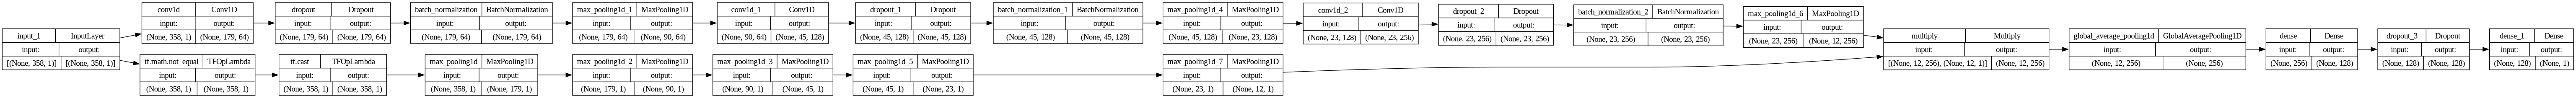

In [13]:
dot_img_file = 'model_1.png'
# plot_model(model, to_file=dot_img_file,  show_shapes=True)
plot_model(model, to_file='model_3.png', show_shapes=True, rankdir='LR')

In [15]:
from keras_visualizer.visualize import visualizer 

ModuleNotFoundError: No module named 'keras_visualizer.visualize'

In [ ]:
visualizer(model, format='png', view=True) 

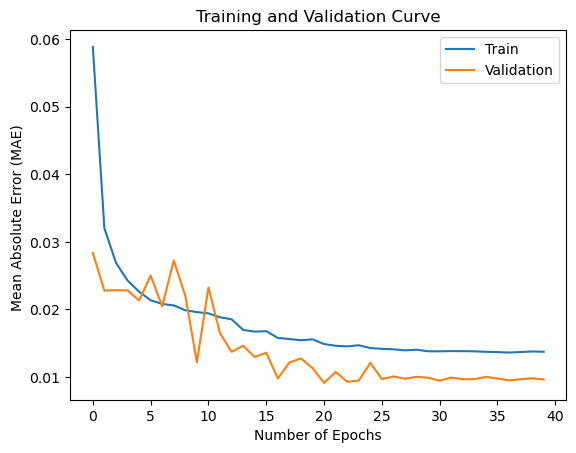

In [13]:
plt.plot(hist['mae'], label = 'Train')
plt.plot(hist['val_mae'], label = 'Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Absolute Error (MAE) ")
plt.title("Training and Validation Curve")
plt.legend()

In [14]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


331/331 [==============================] - 8s 22ms/step
MAE: 0.009499555453658104
MSE: 0.00022786640329286456
R2:  0.9751584529876709


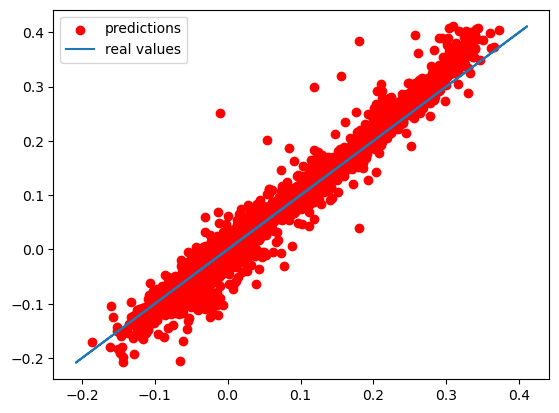

In [15]:
plt.scatter(y_pred, y_test, color = 'red', label = 'predictions')
plt.plot(y_test, y_test, label = 'real values')
plt.legend()

# Saliency Maps

#### definitions for saliency maps

In [16]:
#find the error diff for each prediction and its real values
errors = np.abs(y_pred.flatten() - y_test.flatten())

#find the 5 lowest error diff, and assign its signal, label, p peak and prediction
top5_idx = np.argsort(errors)[:5]
samples = np.stack([X_test[i] for i in top5_idx])
labels = np.stack([y_test[i] for i in top5_idx])
peaks = np.stack([beats_ppks_test[i] for i in top5_idx])
preds = np.stack([y_pred[i] for i in top5_idx])
# this variable is done so we can cut out the padding when plotting
xlim_length = [raw_lengths_test[i] for i in top5_idx]

#same thing but this time for the 5 worst predictions
bottom5_idx = np.argsort(-errors)[:5]
samples_bottom = np.stack([X_test[i] for i in bottom5_idx])
labels_bottom = np.stack([y_test[i] for i in bottom5_idx])
peaks_bottom = np.stack([beats_ppks_test[i] for i in bottom5_idx])
preds_bottom = np.stack([y_pred[i] for i in bottom5_idx])
xlim_length_bottom = [raw_lengths_test[i] for i in bottom5_idx]


#each saliency map needs a score values
def score(inputs):
    return model(inputs)

# def score(output):
#     return output[:, 0]  


#### Vanilla saliency

/tmp/ipykernel_105/543413360.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Vanilla: Top {i+1} pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}") # title each plot
/tmp/ipykernel_105/543413360.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Vanilla: Bottom {i+1} pred  \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")


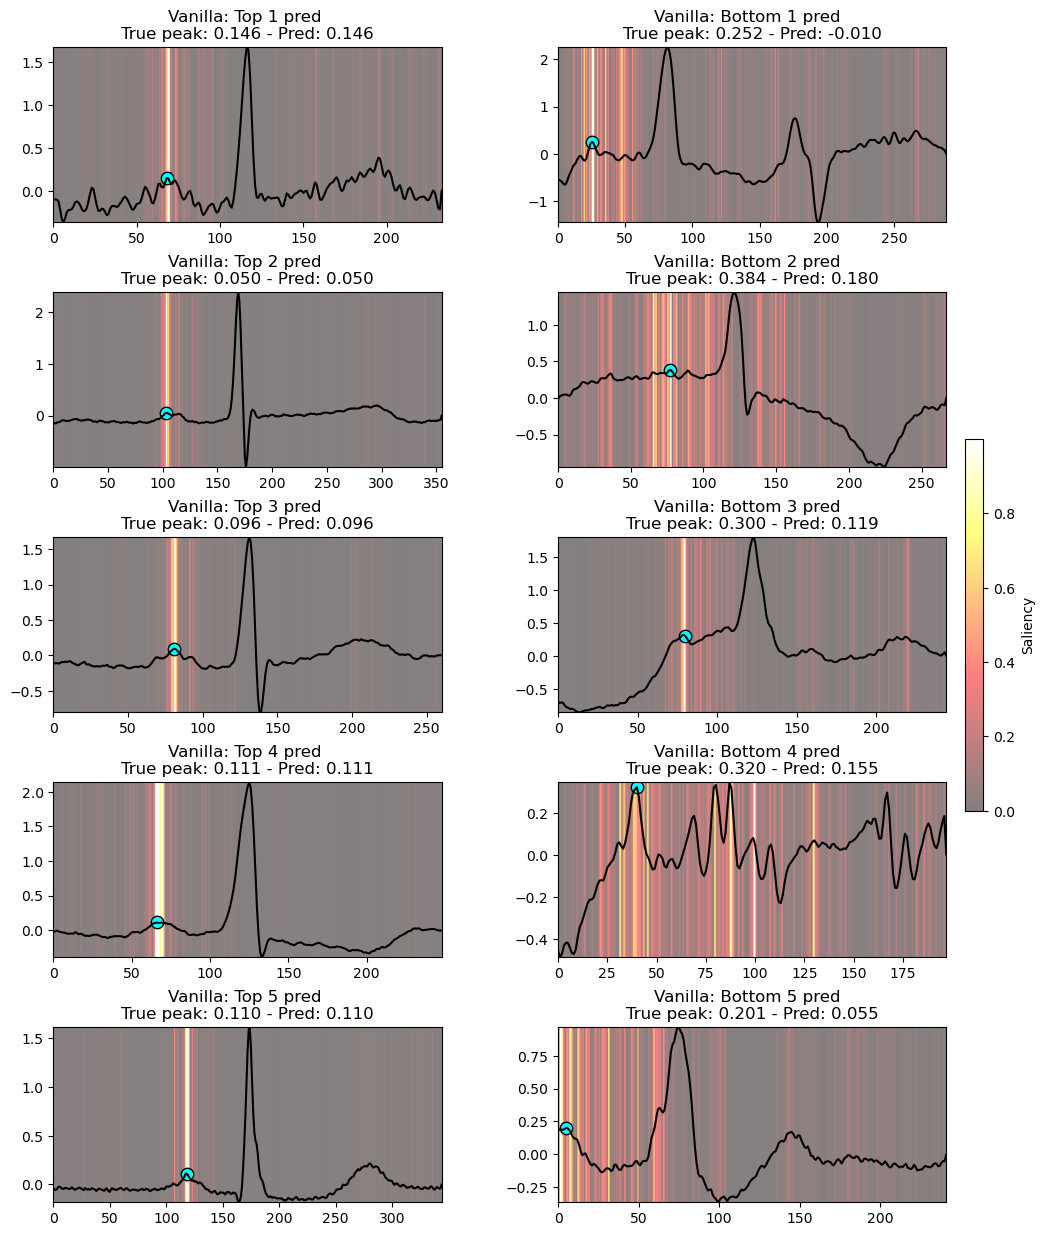

In [17]:
#create vanilla saliency instance
van_saliency = Saliency(model, model_modifier=None, clone=True)

#create subplots to format the plots side by side
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#------------TOP 5----------------
vanilla_saliency_map = van_saliency(score, samples)
for i in range(len(samples)):
    ax = axes[i, 0] # plots on left side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map[i], vanilla_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') # creates a heatmap style over lay
    ax.plot(samples[i, :, 0], color='black', label='ECG') # plot the signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') # Mark the P peak
    ax.set_title(f"Vanilla: Top {i+1} pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}") # title each plot 
    ax.set_xlim(0, xlim_length[i]) #cut off plot when padding starts

#---------------BOTTOM 5-----------------------
#Same as before but the variables have been changed for the bottom 5 predictions
vanilla_saliency_map_bottom = van_saliency(score, samples_bottom)
for i in range(len(samples_bottom)):
    ax = axes[i, 1] #plots on the right side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map_bottom[i], vanilla_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Vanilla: Bottom {i+1} pred  \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])
  
#plot one colour bar that represents all
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [18]:
# save_dir = "vanilla_best_images"
# os.makedirs(save_dir, exist_ok=True)


# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([vanilla_saliency_map[i], vanilla_saliency_map[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"vanilla_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [19]:
# save_dir = "vanilla_worst_images"
# os.makedirs(save_dir, exist_ok=True)


# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([vanilla_saliency_map_bottom[i], vanilla_saliency_map_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"vanilla_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### SmoothGrad

/tmp/ipykernel_105/2708602798.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"SmoothGrad \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/2708602798.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"SmoothGrad \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")


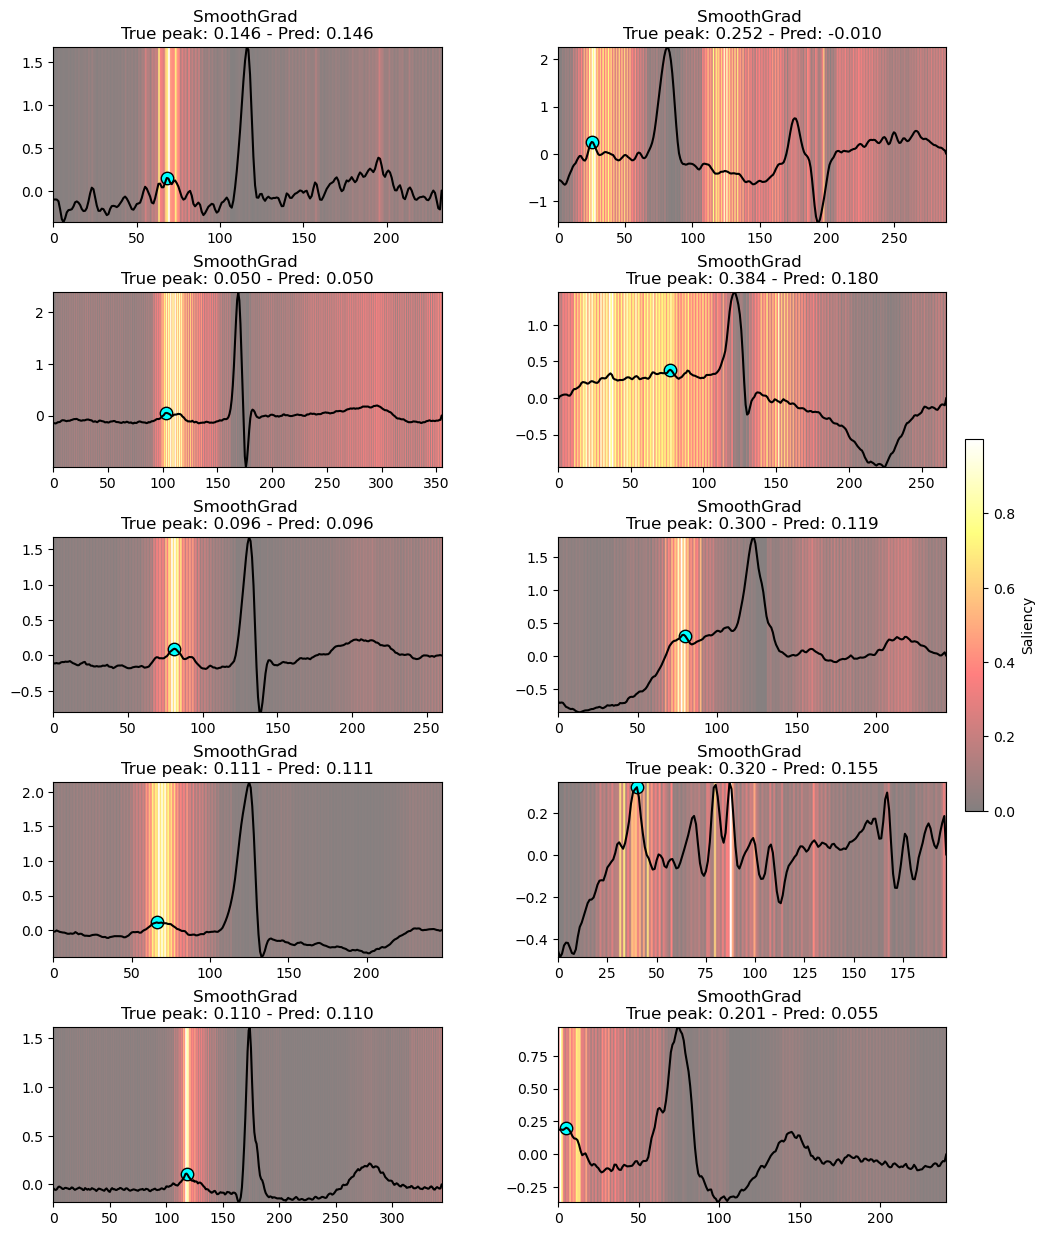

In [20]:
# Create smooth grad saliency instance
sg_saliency = Saliency(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#-------------TOP 5--------------------------
sg_saliency_map = sg_saliency(score,samples,smooth_samples=500,  smooth_noise=0.05)  #generate saliency map with the parameters

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_np = (samples != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map[mask_np == 0] = 0

for i in range(len(samples)):
    ax = axes[i, 0] #plot on left side
    im = ax.imshow(
    np.vstack([sg_saliency_map[i], sg_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') #plots saliency like a heatmap
    ax.plot(samples[i, :, 0], color='black', label='ECG') #plots ECG signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

#-------------------------BOTTOM 5-----------------------------------------

sg_saliency_map_bottom = sg_saliency(score, samples_bottom, smooth_samples=500, smooth_noise=0.05) # keep the parameters the same

mask_np = (samples_bottom != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map_bottom[mask_np == 0] = 0

for i in range(len(samples_bottom)):
    ax = axes[i, 1] #prints on right side
    im = ax.imshow(
    np.vstack([sg_saliency_map_bottom[i], sg_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower')
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [21]:
# save_dir = "sg_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([sg_saliency_map[i], sg_saliency_map[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"sg_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [22]:
# save_dir = "sg_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([sg_saliency_map_bottom[i], sg_saliency_map_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"sg_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### GradCAM

/tmp/ipykernel_105/710046209.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"GradCam: Top {i+1} Pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/710046209.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"GradCam: Bottom {i+1} Pred \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
/tmp/ipykernel_105/710046209.py:69: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axes.ravel().tolist(), 

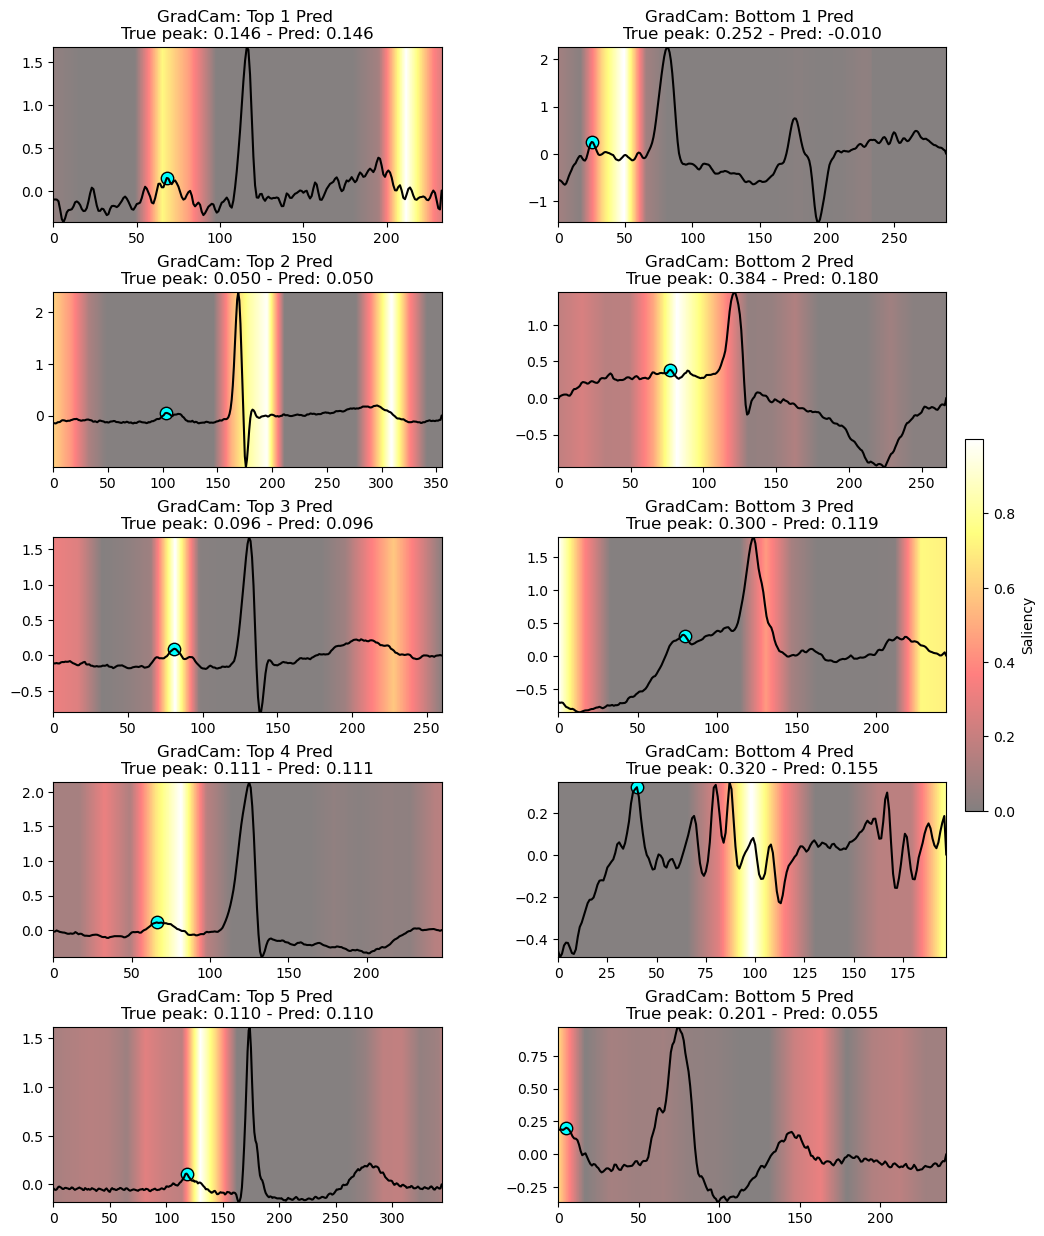

In [23]:
# Get the penultimate Conv1D layer (can use index or layer name)
penultimate_layer = 'conv1d_2'

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5--------------------------------------
# Generate cam
cam_grad = gradcam(score, samples, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad = np.squeeze(mask_cam_grad, axis=-1)       # Remove channel dimension if present

cam_grad[mask_cam_grad == 0] = 0

cam_resized_grad = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_grad
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_resized_grad[i], cam_resized_grad[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Top {i+1} Pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5--------------------------------------

cam_grad_bottom = gradcam(score, samples_bottom, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad_bottom = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad_bottom = np.squeeze(mask_cam_grad_bottom, axis=-1)       # Remove channel dimension if present
cam_grad_bottom[mask_cam_grad_bottom == 0] = 0

cam_grad_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_grad_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_grad_resized_bottom[i], cam_grad_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Bottom {i+1} Pred \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [24]:
# save_dir = "GC_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_resized_grad[i], cam_resized_grad[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"GC_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [25]:
# save_dir = "GC_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_grad_resized_bottom[i], cam_grad_resized_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"GC_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### GradCAM++

/tmp/ipykernel_105/915935850.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"GradCam PlusPlus Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/915935850.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"GradCam PlusPlus Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
/tmp/ipykernel_105/915935850.py:68: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axes.ravel().toli

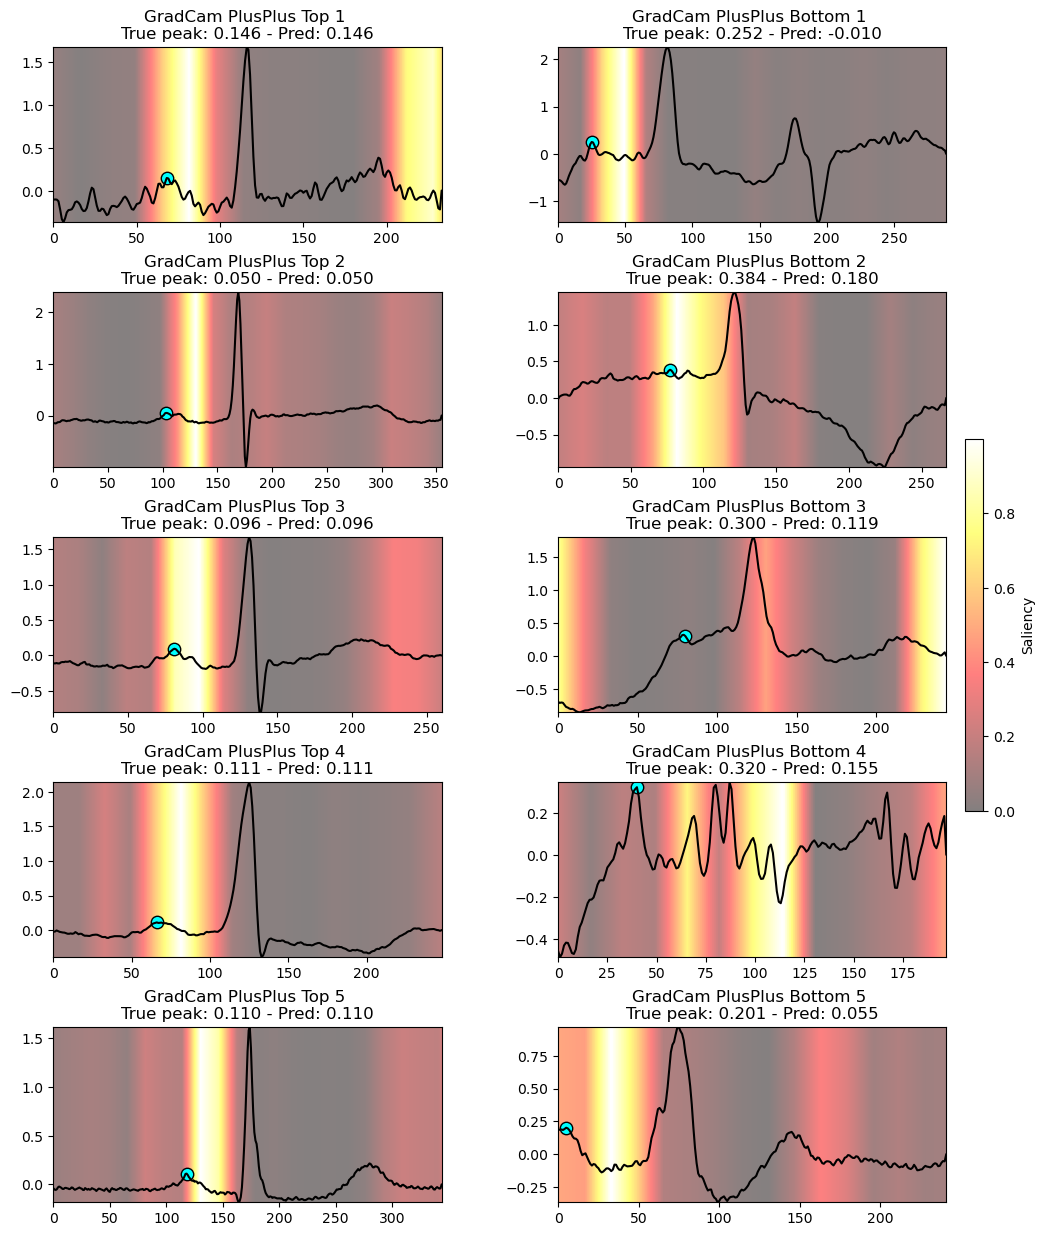

In [26]:
# Create GradCAM++ object
gradcam_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------TOP 5--------------------------

# Generate heatmap with GradCAM++
cam_plus = gradcam_plus(score, samples, penultimate_layer =  penultimate_layer)


mask_cam_plus = (samples != 0).astype(np.float32) 
mask_cam_plus = np.squeeze(mask_cam_plus, axis=-1)
cam_plus[mask_cam_plus == 0] = 0

cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])

#-----------------------------BOTTOM 5-------------------------------

# Generate heatmap with GradCAM++
cam_plus_bottom = gradcam_plus(score, samples_bottom, penultimate_layer =  penultimate_layer)

# After computing sg_saliency_map
mask_cam_plus_bottom = (samples_bottom != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_plus_bottom = np.squeeze(mask_cam_plus_bottom, axis=-1)       # Remove channel dimension if present
cam_plus_bottom[mask_cam_plus_bottom == 0] = 0

cam_plus_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_plus_bottom
])


for i in range(len(samples)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_plus_resized_bottom[i], cam_plus_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [27]:
# save_dir = "GC++_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"GC++_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [28]:
# save_dir = "GC++_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_plus_resized_bottom[i], cam_plus_resized_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"GC++_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### ScoreCAM

 1/40 [..............................] - ETA: 1s

/tmp/ipykernel_105/4215900287.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"ScoreCAM Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")


40/40 [==============================] - 1s 22ms/step


/tmp/ipykernel_105/4215900287.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
/tmp/ipykernel_105/4215900287.py:54: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)


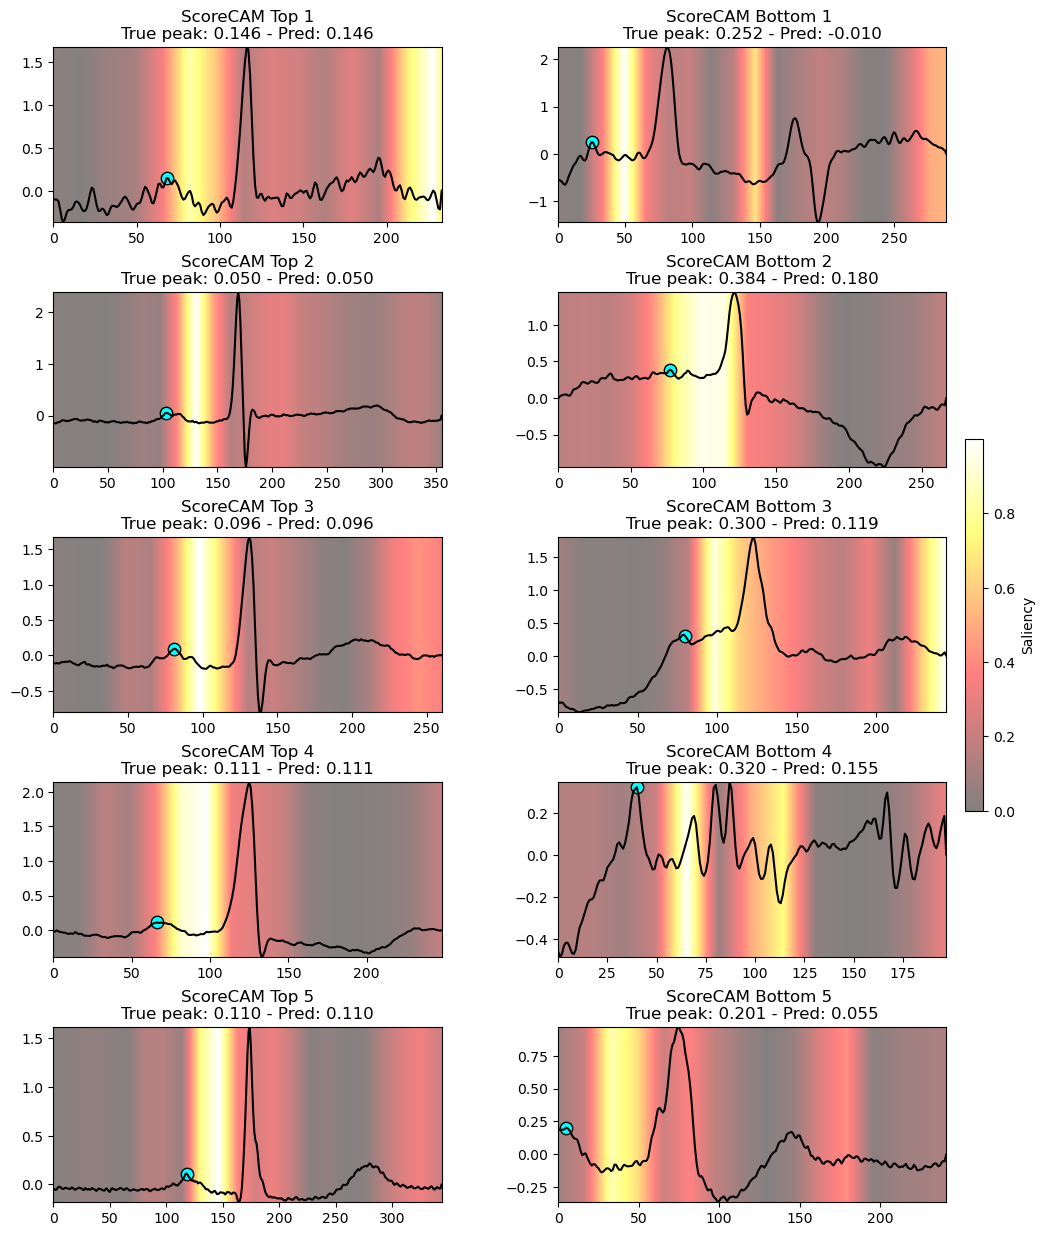

In [29]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------------------TOP 5-----------------------
# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5-------------------
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])


for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [30]:
# save_dir = "scorecam_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_resized[i], cam_resized[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"scorecam_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [31]:
# save_dir = "scorecam_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"scorecam_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### Faster ScoreCAM

4/4 [==============================] - 0s 17ms/step


/tmp/ipykernel_105/250961738.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"ScoreCAM Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/250961738.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
/tmp/ipykernel_105/250961738.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0

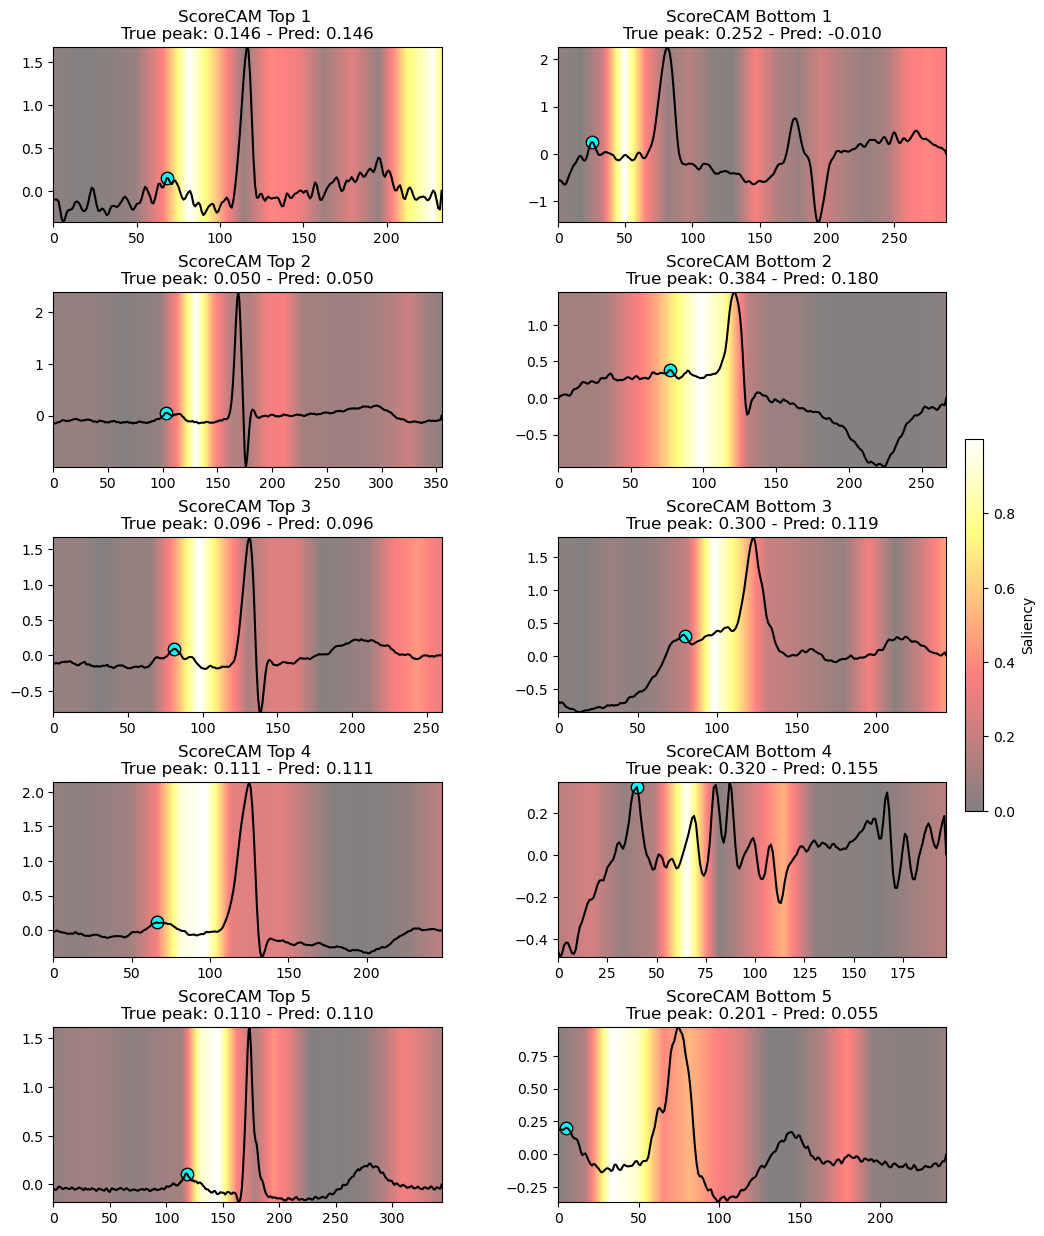

In [32]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#---------------------TOP 5-----------------------
cam = scorecam(score, samples, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])


for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#----------------------BOTTOM 5-----------------------------

# Generate heatmap with ScoreCAM
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [33]:
# save_dir = "fastscorecam_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_resized[i], cam_resized[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"fastscorecam_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [34]:
# save_dir = "fastscorecam_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"fastscorecam_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### Guided BackPropagation

/tmp/ipykernel_105/3268863775.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Guided BackPropagation Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/3268863775.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Guided BackPropagation Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")


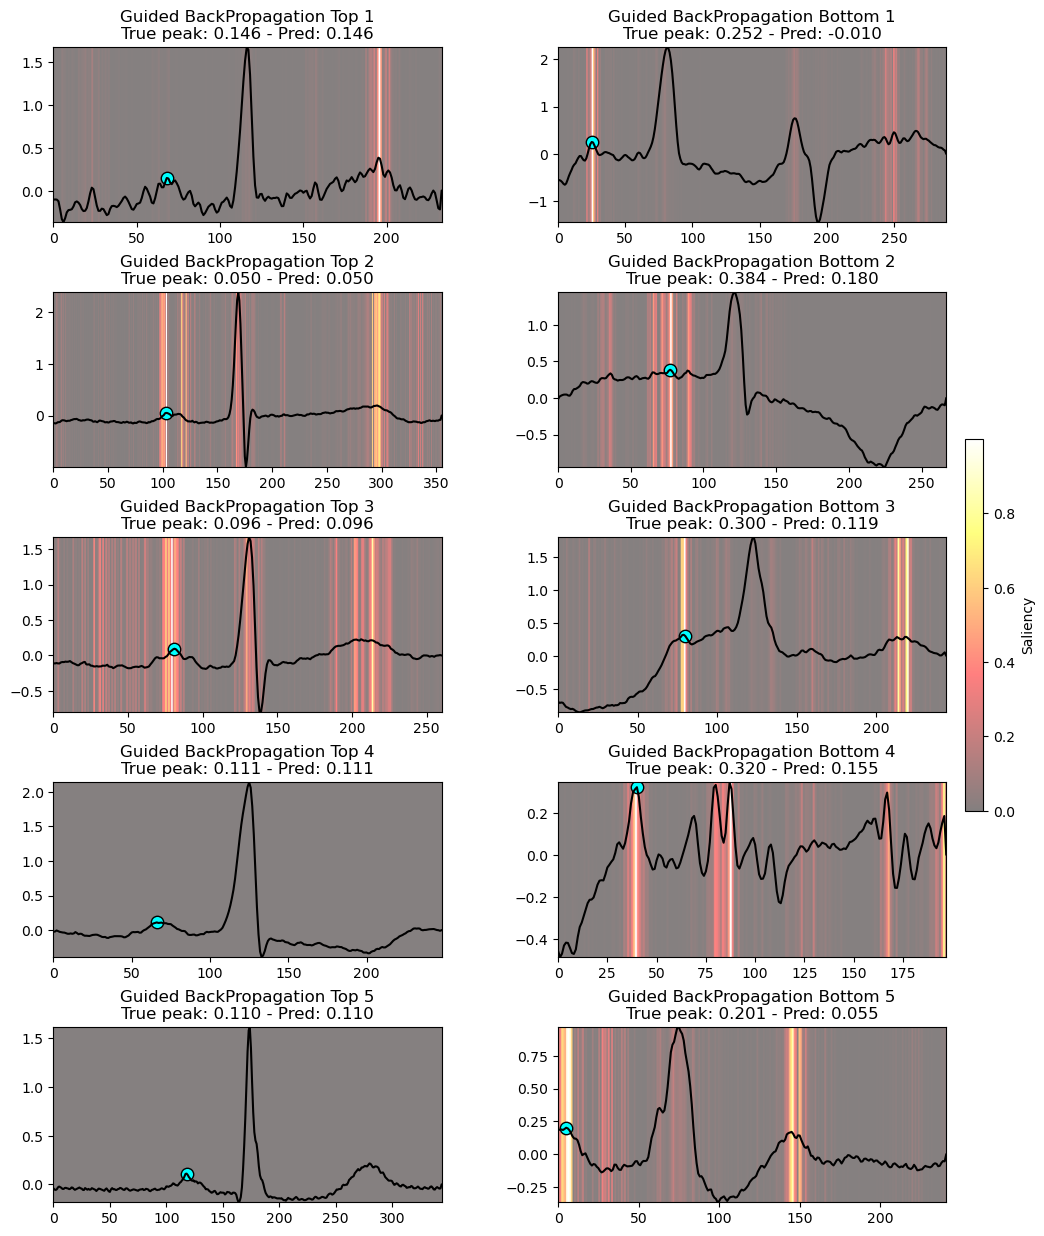

In [35]:
gb_saliency = Saliency(model, model_modifier=GuidedBackpropagation(), clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------TOP 5--------------------------

gb_saliency_map = gb_saliency(score, samples)

for i in range(len(samples)):
    ax = axes[i, 0]
    im = ax.imshow(
    np.vstack([gb_saliency_map[i], gb_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#-----------------------BOTTOM 5-------------------------
gb_saliency_map_bottom = gb_saliency(score, samples_bottom)

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    im = ax.imshow(
    np.vstack([gb_saliency_map_bottom[i], gb_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

In [36]:
# save_dir = "backprop_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([gb_saliency_map[i], gb_saliency_map[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"backprop_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [37]:
# save_dir = "backprop_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([gb_saliency_map_bottom[i], gb_saliency_map_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"backprop_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### Guided GradCAM

/tmp/ipykernel_105/4020371108.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Guided GradCam Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
/tmp/ipykernel_105/4020371108.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Guided GradCam Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")


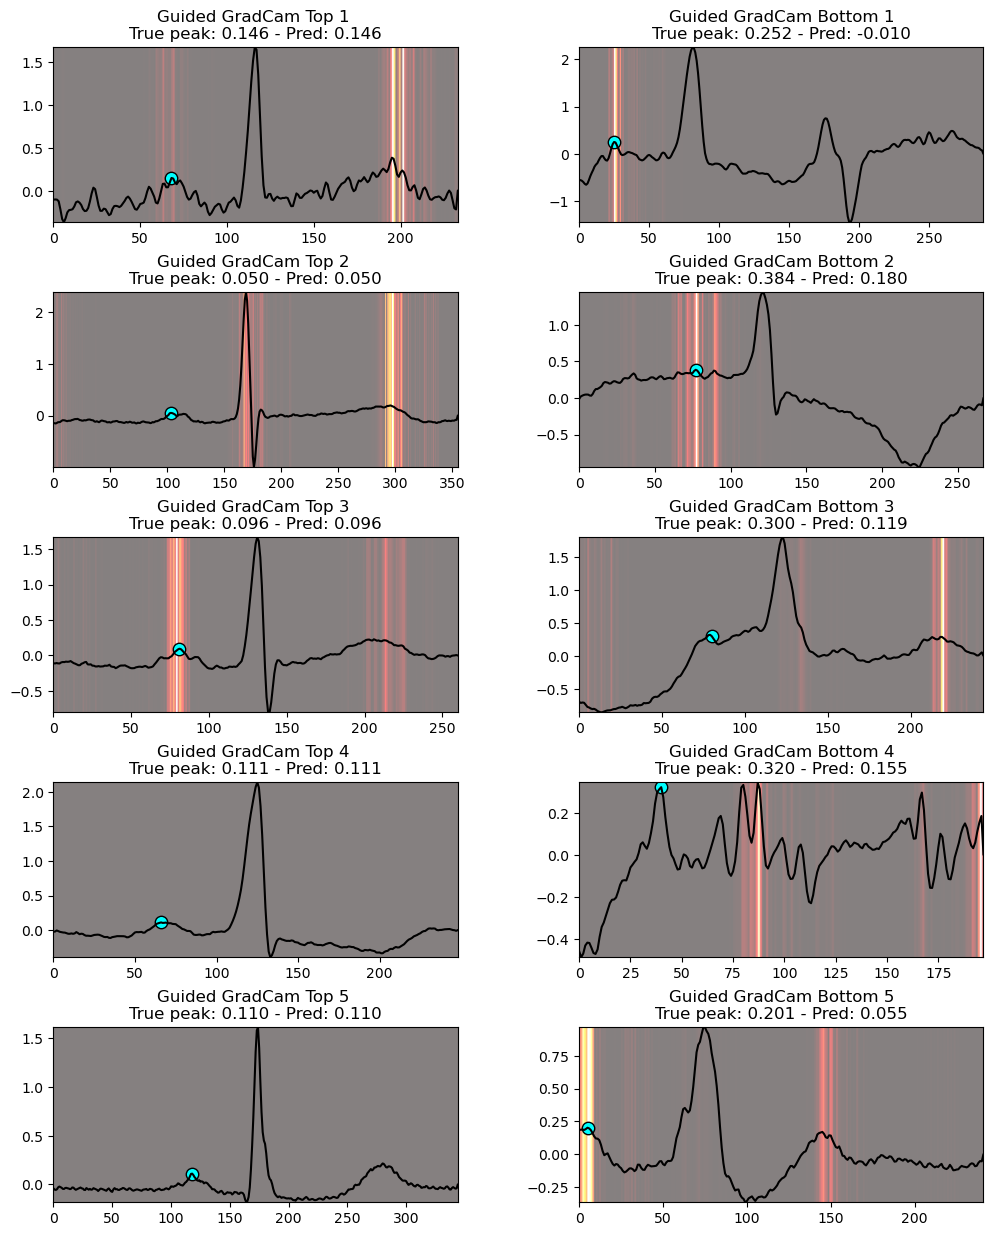

In [38]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5------------------------

guided_gradcam = gb_saliency_map * cam_resized_grad
for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
    np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])
    
#-----------------BOTTOM 5-------------------------

guided_gradcam_bottom = gb_saliency_map_bottom * cam_grad_resized_bottom
for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
    np.vstack([guided_gradcam_bottom[i], guided_gradcam_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

In [39]:
# save_dir = "guidedGC_best_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks[i], samples[i][peaks[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"guidedGC_best_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

In [40]:
# save_dir = "guidedFC_worst_images"
# os.makedirs(save_dir, exist_ok=True)

# for i in range(len(samples_bottom)):
#     fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
#     # Heatmap overlay
#     ax.imshow(
#         np.vstack([guided_gradcam_bottom[i], guided_gradcam_bottom[i]]), 
#         cmap='hot', aspect='auto', alpha=0.5,
#         extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
#         origin='lower'
#     )
    
#     # ECG line
#     ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    
#     # P-peaks
#     ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]], 
#                c='cyan', edgecolors='k', s=80, label='P-Peak')
    
#     ax.set_xlim(0, xlim_length_bottom[i])
#     ax.axis("off")
    
#     # Save image
#     filename = os.path.join(save_dir, f"guidedGC_worst_pred{i+1}.png")
#     plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
#     plt.close(fig)

#### Average saliency map

In [41]:
#find index of top 100 predictions
top100_idx = np.argsort(errors)[:100]
#gather the signals
signals_top100 = X_test[top100_idx]
labels_top100 = y_test[top100_idx]
#find their r peaks
r_peaks = [beats_rpks_test[i] for i in top100_idx]

#get saliency for each technqiue on the top 100
vanilla_saliency_map_avg = van_saliency(score, signals_top100)
sg_saliency_map_avg = sg_saliency(score, signals_top100, smooth_samples=500, smooth_noise=0.05) 
cam_grad_avg = gradcam(score, signals_top100, penultimate_layer=penultimate_layer)
cam_plus_avg = gradcam_plus(score, signals_top100, penultimate_layer =  penultimate_layer)
cam_score_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer)
cam_fastscore_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer,  max_N=10)
gb_saliency_map_avg = gb_saliency(score, signals_top100)
guided_gradcam_avg = gb_saliency_map_avg * cam_grad_avg

all_avg_saliency = [vanilla_saliency_map_avg, sg_saliency_map_avg, cam_grad_avg, cam_plus_avg, cam_score_avg, cam_fastscore_avg, gb_saliency_map_avg, guided_gradcam_avg]
title_sal = ['Vanilla', 'SmoothGrad', 'GradCam', 'GradCamPlus', 'ScoreCam', 'Faster ScoreCam', 'Guided BackPropagation', 'Guided GradCam']

235/235 [==============================] - 5s 22ms/step


In [42]:
#find the center of the signal, where all R peaks will be aligned
center = signals_top100.shape[1] // 2
# create a new array of shape (100, 778) filled with zeros, to hold the shifted beats.
aligned = np.zeros_like(signals_top100)

# shift each beat so its R-peak lands at center
for n, (sig, r_loc) in enumerate(zip(signals_top100, r_peaks)):
    shift = center - r_loc
    aligned[n] = np.roll(sig, shift)

#compute avg ecg
avg_aligned = np.mean(aligned, axis=0)



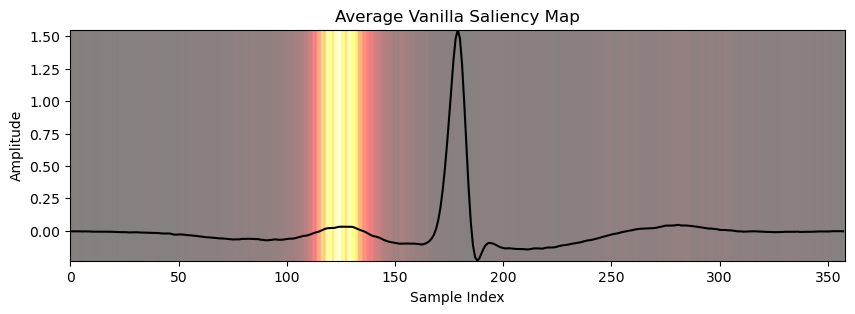

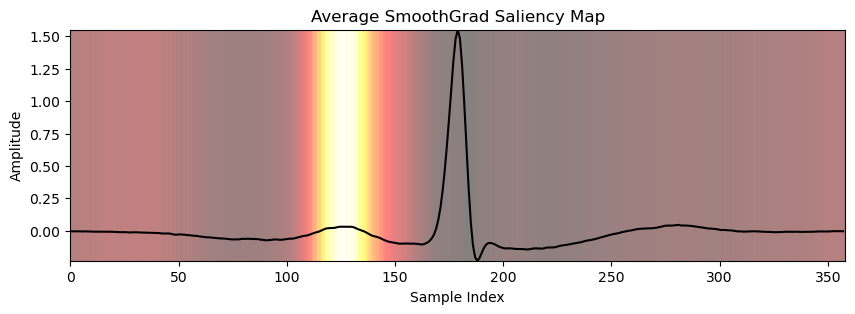

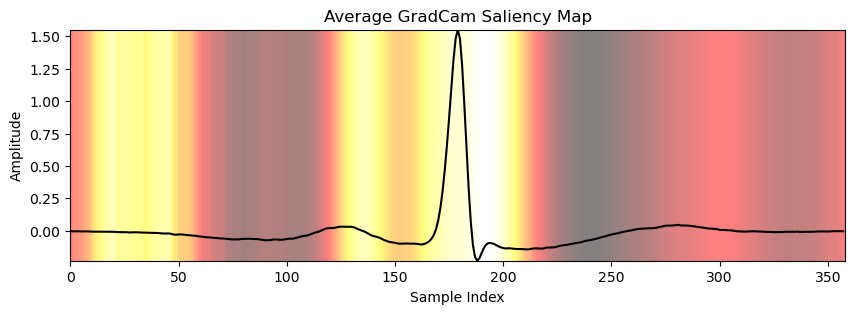

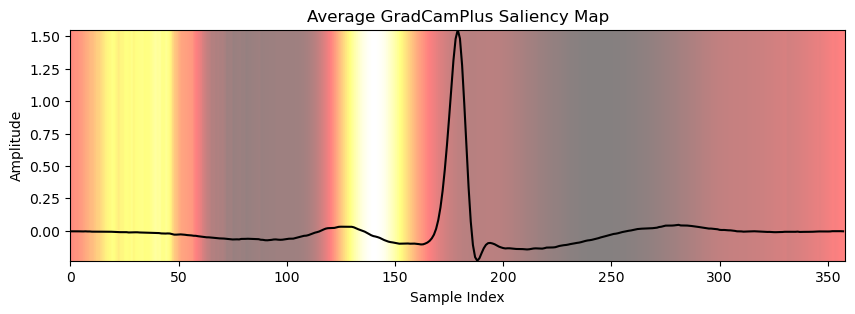

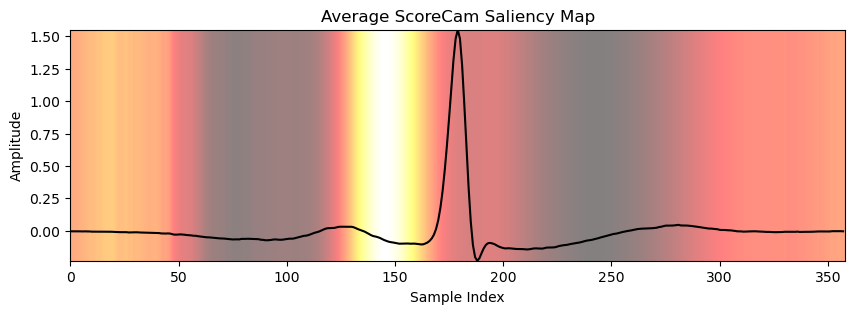

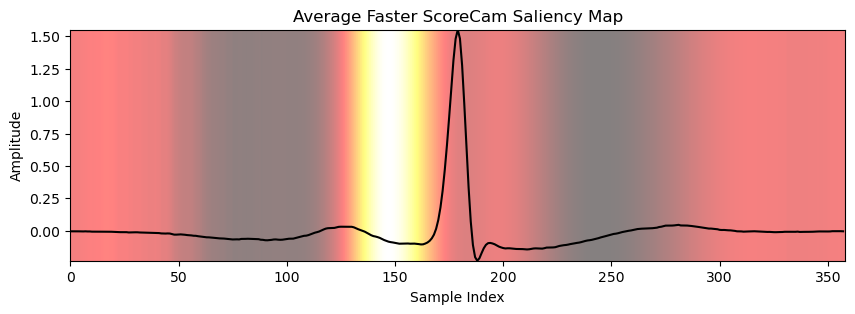

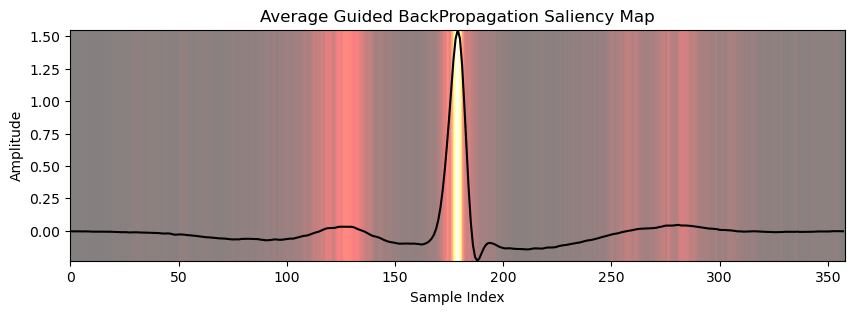

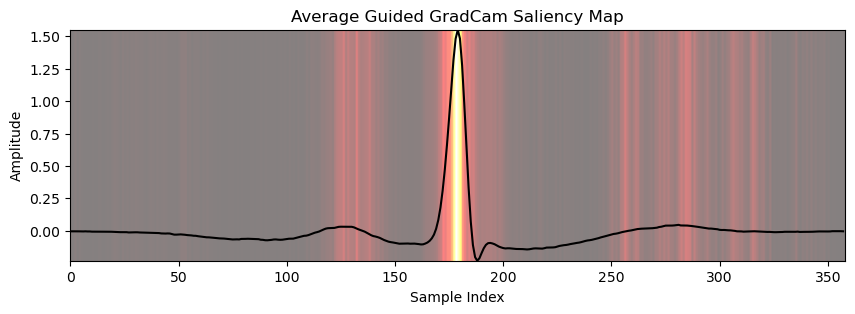

In [43]:
for i, sal in enumerate(all_avg_saliency):
    aligned_sal = np.zeros_like(sal)
    
    for n, r_loc in enumerate(r_peaks):
        shift = center - r_loc
        aligned_sal[n] = np.roll(sal[n], shift)
    
    avg_saliency = aligned_sal.mean(axis=0)

    # plt.figure(figsize=(10, 3))
    # plt.plot(avg_aligned)
    # plt.plot(avg_saliency)
    # plt.title(f"Average {title_sal[i]} Saliency Map")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    # plt.tight_layout()
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 3))

    ax.imshow(
        np.vstack([avg_saliency, avg_saliency]), cmap='hot', aspect='auto',alpha=0.5,
        extent=[0, len(avg_aligned), avg_aligned.min(), avg_aligned.max()], origin='lower')
    
    ax.plot(avg_aligned, color = 'black')
    ax.set_title(f"Average {title_sal[i]} Saliency Map")
    ax.set_xlim(0, len(avg_aligned))
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    plt.show()

In [44]:
save_dir = "average_saliency_images"
os.makedirs(save_dir, exist_ok=True)


for i, sal in enumerate(all_avg_saliency):
    aligned_sal = np.zeros_like(sal)
    
    for n, r_loc in enumerate(r_peaks):
        shift = center - r_loc
        aligned_sal[n] = np.roll(sal[n], shift)
    
    avg_saliency = aligned_sal.mean(axis=0)
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    ax.imshow(
        np.vstack([avg_saliency, avg_saliency]), cmap='hot', aspect='auto',alpha=0.5,
        extent=[0, len(avg_aligned), avg_aligned.min(), avg_aligned.max()], origin='lower')
    
    # ECG line
    ax.plot(avg_aligned, color = 'black')
    
    
    ax.set_xlim(0, len(avg_aligned))
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"{title_sal[i]}_avg_saliency.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

# Activation Maximization

#### Last Conv Layer

200/200 [==============================] - 9s 47ms/step - Score: 9405.2686 - Norm: 636.5344


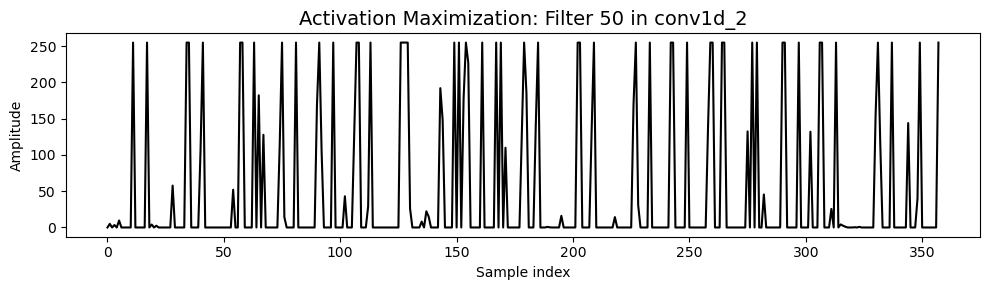

200/200 [==============================] - 9s 46ms/step - Score: -10.2369 - Norm: 23.4315


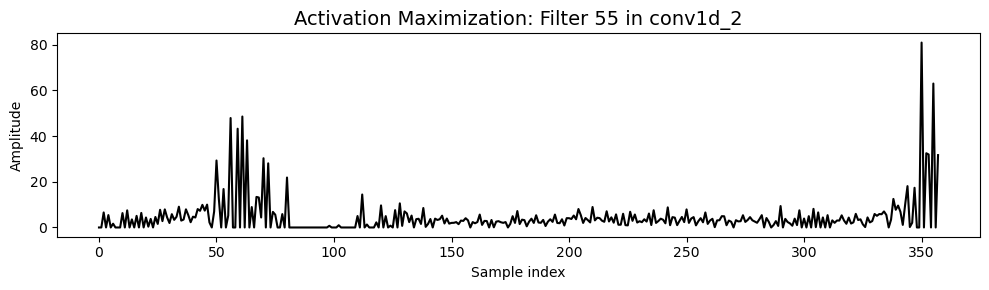

200/200 [==============================] - 10s 48ms/step - Score: 3193.4695 - Norm: 509.8696


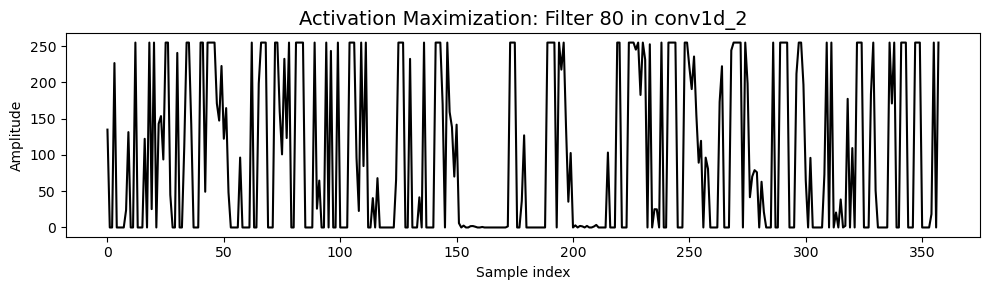

200/200 [==============================] - 9s 45ms/step - Score: 850.2805 - Norm: 191.8146


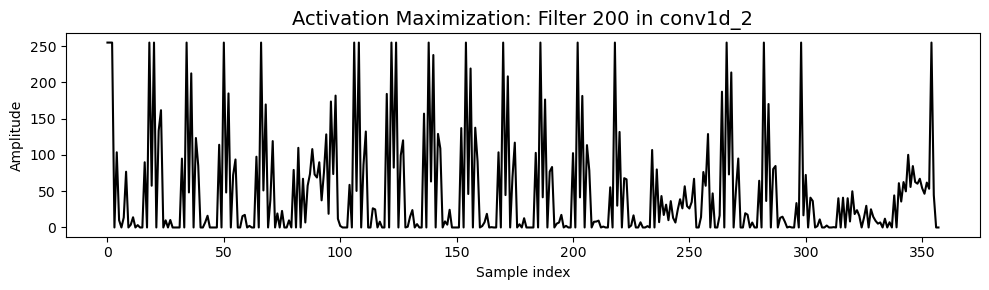

200/200 [==============================] - 9s 45ms/step - Score: -11.2235 - Norm: 15.5214


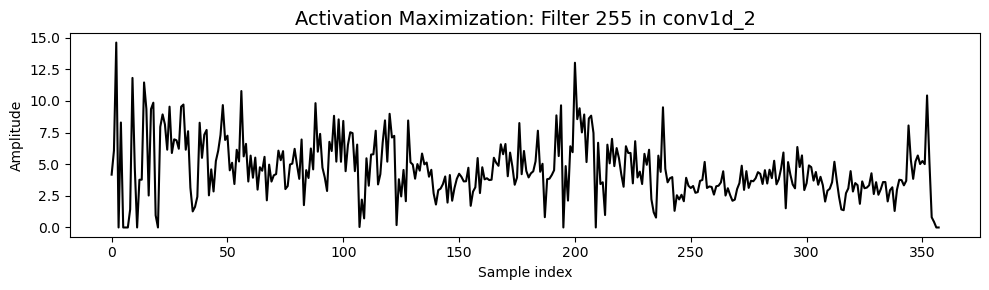

In [45]:
layer_name = 'conv1d_2' #target layer

#new model whose output is replaced to `block5_conv3` layer's output
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
#modify the model's last activation function to linear
replace2linear = ReplaceToLinear()

activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

filter_numbers = [50,55,80,200,255]
nrows = 1
ncols = len(filter_numbers)


for idx, i in enumerate(filter_numbers):
    def score_am(output):
        return tf.reduce_mean(output[:, :, i])

    # Generate maximized activation
    activations = activation_maximization(score_am, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
    activations = activations.numpy()

    plt.figure(figsize=(10, 3))
    plt.plot(activations[0].squeeze(), color='black')
    plt.title(f'Activation Maximization: Filter {i} in {layer_name}', fontsize=14)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

#### Dense layer

200/200 [==============================] - 13s 66ms/step - Score: 19874.8340 - Norm: 612.6496


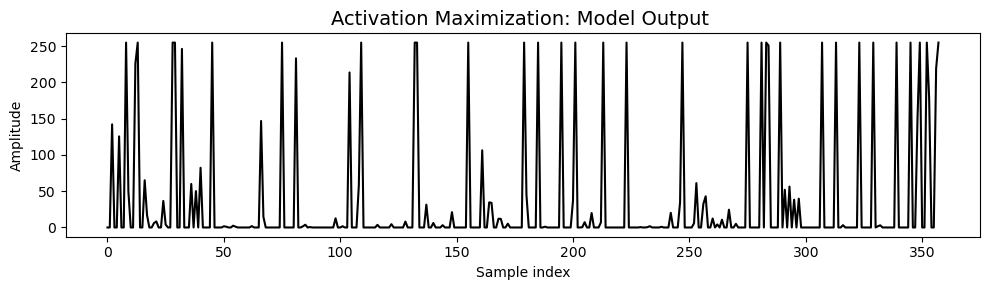

In [46]:
def score_dense(output):
    return output[:, 0]
    
activation_maximization = ActivationMaximization(model, model_modifier = None, clone=True)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

# Generate maximized activation
activations = activation_maximization(score_dense, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
activations = activations.numpy()

plt.figure(figsize=(10, 3))
plt.plot(activations[0].squeeze(), color='black')
plt.title(f'Activation Maximization: Model Output ', fontsize=14)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [47]:
X_train_2d = np.squeeze(X_train)
samples_2d  = np.squeeze(samples)
samples_bottom_2d  = np.squeeze(samples_bottom)


T = X_train_2d.shape[1]
feature_names = [f"t{i}" for i in range(T)]

explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train_2d, feature_names = feature_names, mode= 'regression', discretize_continuous=False)

predict_fn = lambda x: model.predict( x.reshape(-1, T, 1)).ravel()

exp = explainer.explain_instance(samples_2d[0], predict_fn, num_features = 358, num_samples  = 5000)


157/157 [==============================] - 4s 23ms/step


In [48]:
exp.show_in_notebook(show_table=True)

157/157 [==============================] - 4s 24ms/step


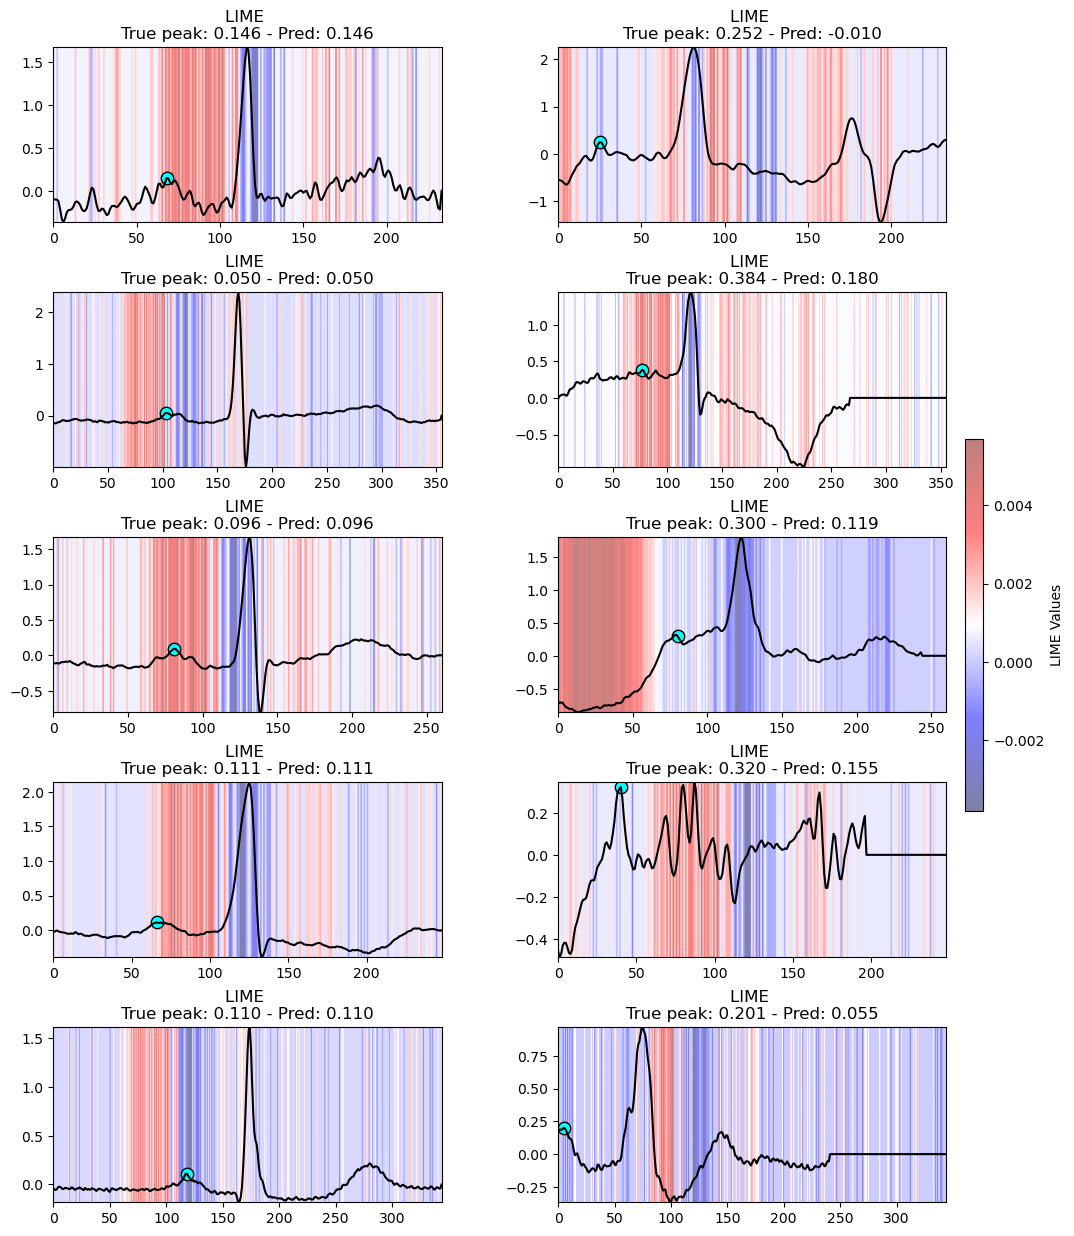

In [49]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

for i in range(len(samples_2d)):
    exp = explainer.explain_instance(samples_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    feat_weights = []
    for f, w in exp.as_list():
        f = int(f[1:])
        feat_weights.append((f,w))
    
    feat_weights.sort(key=lambda x: x[0])
    features, weights = zip(*feat_weights)

    weights = np.array(weights)  
    top_idxs = np.argsort(np.abs(weights))[-150:]  
    top_weights = np.zeros_like(weights)          
    top_weights[top_idxs] = weights[top_idxs] 

    ax = axes[i, 0]
    im = ax.imshow(
    np.vstack([top_weights, top_weights]), 
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, samples_2d.shape[1], samples_2d[i, :].min(), samples_2d[i, :].max()],
    origin='lower') #plots saliency like a heatmap
    
    ax.plot(samples_2d[i, :], color='black', label='ECG') #plots ECG signal
    
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    
    ax.set_title(f"LIME \nTrue peak: {float(labels[i].item()):.3f} - Pred: {float(preds[i].item()):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

for i in range(len(samples_2d)):
    exp = explainer.explain_instance(samples_bottom_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    feat_weights = []
    for f, w in exp.as_list():
        f = int(f[1:])
        feat_weights.append((f,w))
    
    feat_weights.sort(key=lambda x: x[0])
    features, weights = zip(*feat_weights)

    weights = np.array(weights)  
    top_idxs = np.argsort(np.abs(weights))[-150:]  
    top_weights_bottom = np.zeros_like(weights)          
    top_weights_bottom[top_idxs] = weights[top_idxs] 

    ax = axes[i, 1]
    im = ax.imshow(
    np.vstack([top_weights_bottom, top_weights_bottom]), 
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom_2d.shape[1], samples_bottom_2d[i, :].min(), samples_bottom_2d[i, :].max()],
    origin='lower') #plots saliency like a heatmap
    
    ax.plot(samples_bottom_2d[i, :], color='black', label='ECG') #plots ECG signal
    
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    
    ax.set_title(f"LIME \nTrue peak: {float(labels_bottom[i].item()):.3f} - Pred: {float(preds_bottom[i].item()):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("LIME Values")

In [50]:
save_dir = "LIME_best_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    exp = explainer.explain_instance(samples_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    feat_weights = []
    for f, w in exp.as_list():
        f = int(f[1:])
        feat_weights.append((f,w))
    
    feat_weights.sort(key=lambda x: x[0])
    features, weights = zip(*feat_weights)

    weights = np.array(weights)  
    top_idxs = np.argsort(np.abs(weights))[-150:]  
    top_weights = np.zeros_like(weights)          
    top_weights[top_idxs] = weights[top_idxs] 
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([top_weights, top_weights]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_2d.shape[1], samples_2d[i, :].min(), samples_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"LIME_best_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

157/157 [==============================] - 4s 24ms/step


In [51]:
save_dir = "LIME_worst_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    exp = explainer.explain_instance(samples_bottom_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    feat_weights = []
    for f, w in exp.as_list():
        f = int(f[1:])
        feat_weights.append((f,w))
    
    feat_weights.sort(key=lambda x: x[0])
    features, weights = zip(*feat_weights)

    weights = np.array(weights)  
    top_idxs = np.argsort(np.abs(weights))[-150:]  
    top_weights_bottom = np.zeros_like(weights)          
    top_weights_bottom[top_idxs] = weights[top_idxs] 
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([top_weights_bottom, top_weights_bottom]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom_2d.shape[1], samples_bottom_2d[i, :].min(), samples_bottom_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_bottom_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length_bottom[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"LIME_worst_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

157/157 [==============================] - 4s 24ms/step


# DLIME

In [52]:
bg_idx = np.random.choice(X_train_2d.shape[0], size=20000, replace=False)
X_bg   = X_train_2d[bg_idx]

cluster_labels = AgglomerativeClustering(n_clusters=25).fit_predict(X_bg)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_bg, cluster_labels)

KNeighborsClassifier()

157/157 [==============================] - 4s 24ms/step


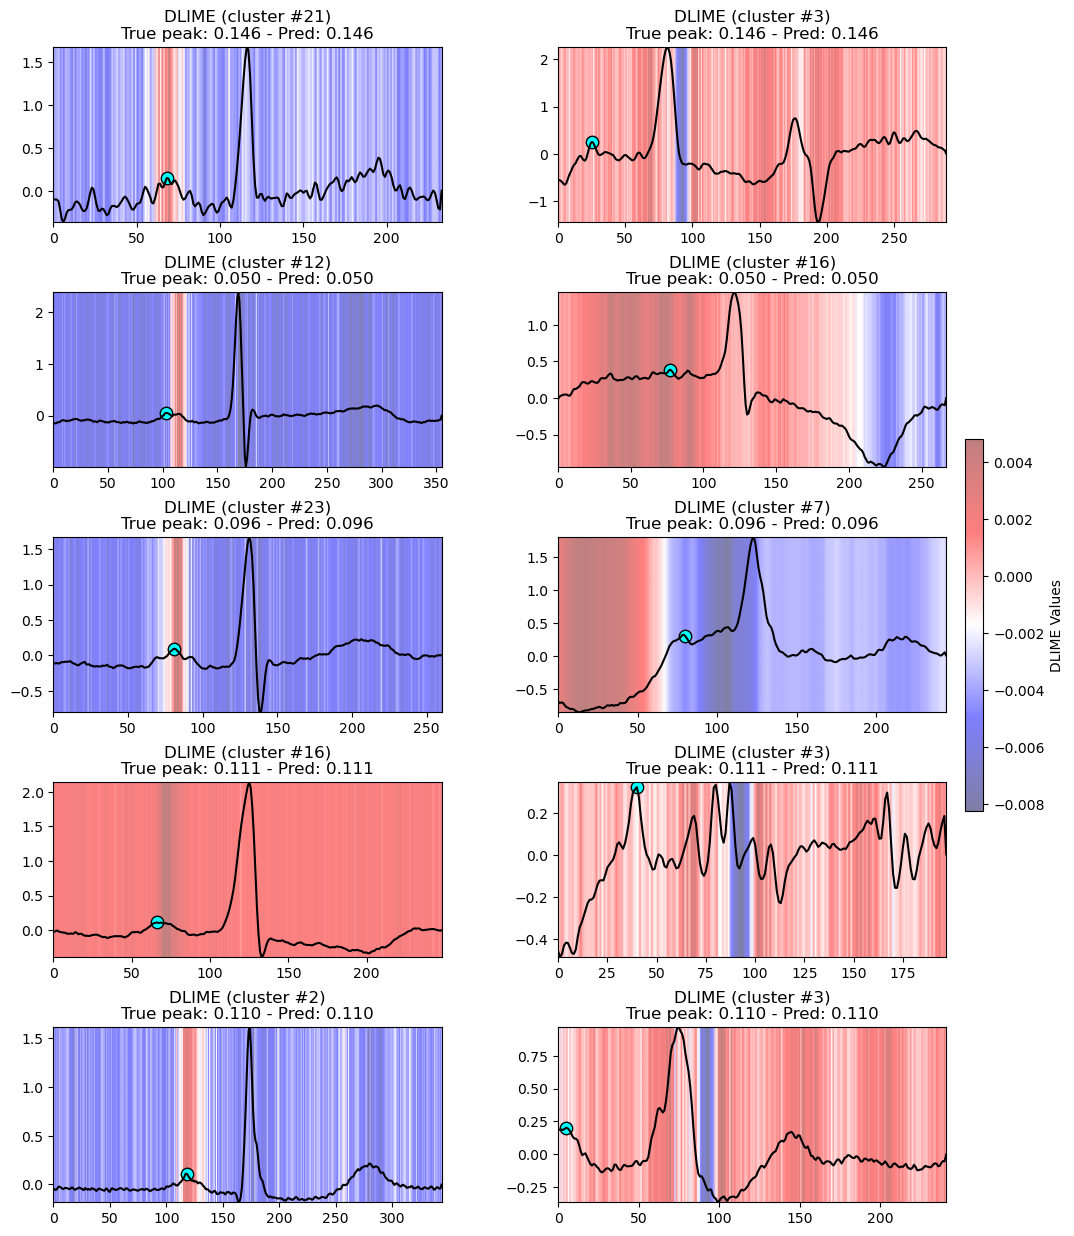

In [53]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)
for i in range(len(samples_2d)):
    clust = knn.predict(samples_2d[i].reshape(1, -1))[0]
    cluster_data = X_bg[cluster_labels == clust]      

    explainer = lime.lime_tabular.LimeTabularExplainer(training_data= cluster_data, feature_names= feature_names, mode= 'regression', discretize_continuous=False)
    exp = explainer.explain_instance(samples_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    
    feat_weights = [(int(f[1:]), w) for f,w in exp.as_list()]
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    weights = np.array(weights)

    ax = axes[i, 0]
    im = ax.imshow(
        np.vstack([weights, weights]),
        cmap='seismic',
        aspect='auto', alpha=0.5,
        extent=[0, T, samples_2d[i].min(), samples_2d[i].max()],
        origin='lower'
    )
    ax.plot(samples_2d[i], color='black', label='ECG')
    ax.scatter(peaks[i], samples[i][peaks[i]],c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"DLIME (cluster #{clust})\n"f"True peak: {labels[i].item():.3f} - Pred: {preds[i].item():.3f}")
    ax.set_xlim(0, xlim_length[i])

for i in range(len(samples_bottom_2d)):
    clust = knn.predict(samples_bottom_2d[i].reshape(1, -1))[0]
    cluster_data = X_bg[cluster_labels == clust]      

    explainer = lime.lime_tabular.LimeTabularExplainer(training_data= cluster_data, feature_names= feature_names, mode= 'regression', discretize_continuous=False)
    exp = explainer.explain_instance(samples_bottom_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    
    feat_weights = [(int(f[1:]), w) for f,w in exp.as_list()]
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    weights = np.array(weights)

    ax = axes[i, 1]
    im = ax.imshow(
        np.vstack([weights, weights]),
        cmap='seismic',
        aspect='auto', alpha=0.5,
        extent=[0, T, samples_bottom_2d[i].min(), samples_bottom_2d[i].max()],
        origin='lower'
    )
    ax.plot(samples_bottom_2d[i], color='black', label='ECG')
    ax.scatter(peaks_bottom[i], samples_bottom[i][peaks_bottom[i]],c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"DLIME (cluster #{clust})\n"f"True peak: {labels[i].item():.3f} - Pred: {preds[i].item():.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("DLIME Values")

### save pics

In [54]:
save_dir = "Det_LIME_best_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    clust = knn.predict(samples_2d[i].reshape(1, -1))[0]
    cluster_data = X_bg[cluster_labels == clust]      

    explainer = lime.lime_tabular.LimeTabularExplainer(training_data= cluster_data, feature_names= feature_names, mode= 'regression', discretize_continuous=False)
    exp = explainer.explain_instance(samples_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    
    feat_weights = [(int(f[1:]), w) for f,w in exp.as_list()]
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    weights = np.array(weights)
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([weights, weights]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_2d.shape[1], samples_2d[i, :].min(), samples_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"det_LIME_best_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

157/157 [==============================] - 3s 20ms/step


In [55]:
save_dir = "det_LIME_worst_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    clust = knn.predict(samples_bottom_2d[i].reshape(1, -1))[0]
    cluster_data = X_bg[cluster_labels == clust]      

    explainer = lime.lime_tabular.LimeTabularExplainer(training_data= cluster_data, feature_names= feature_names, mode= 'regression', discretize_continuous=False)
    exp = explainer.explain_instance(samples_bottom_2d[i], predict_fn, num_features = 358, num_samples  = 5000)
    
    feat_weights = [(int(f[1:]), w) for f,w in exp.as_list()]
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    weights = np.array(weights)
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([weights, weights]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom_2d.shape[1], samples_bottom_2d[i, :].min(), samples_bottom_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_bottom_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length_bottom[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"det_LIME_worst_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

157/157 [==============================] - 4s 24ms/step


# SHAP

In [56]:
background = X_train[:1000]
explainer = shap.GradientExplainer(model, background)

/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
/tmp/ipykernel_105/2472352905.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_flat, test_flat)


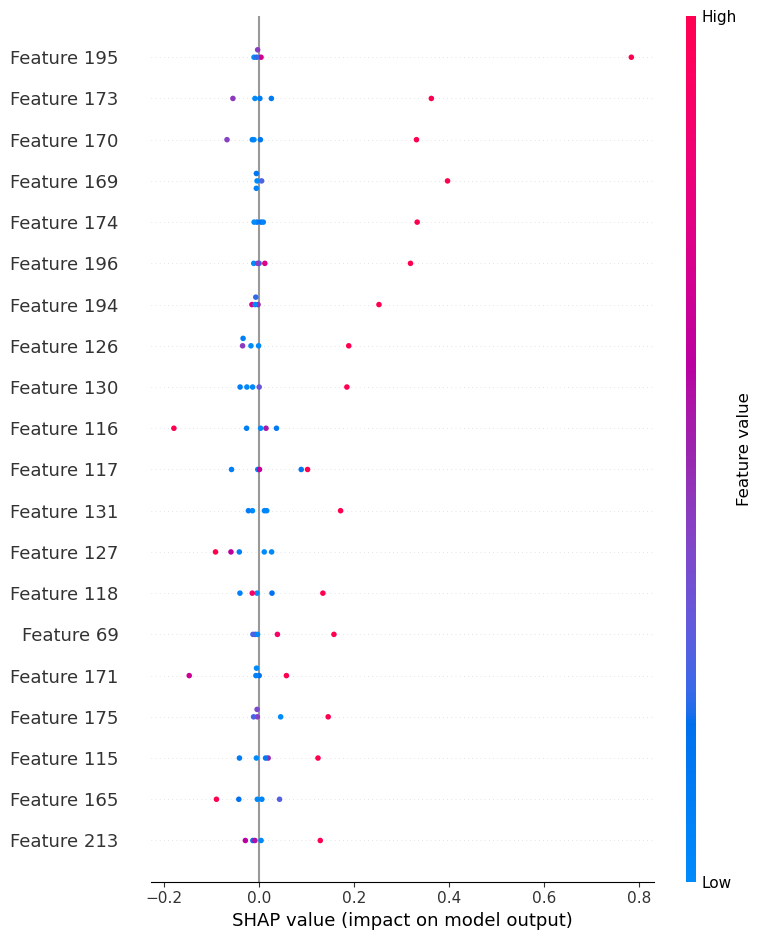

In [57]:
shap_values = explainer.shap_values(samples)
shap_flat = shap_values.reshape(shap_values.shape[0], -1)
test_flat = samples.reshape(samples.shape[0], -1)
shap.summary_plot(shap_flat, test_flat)

/tmp/ipykernel_105/3782424780.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_flat_bottom, test_flat_bottom)


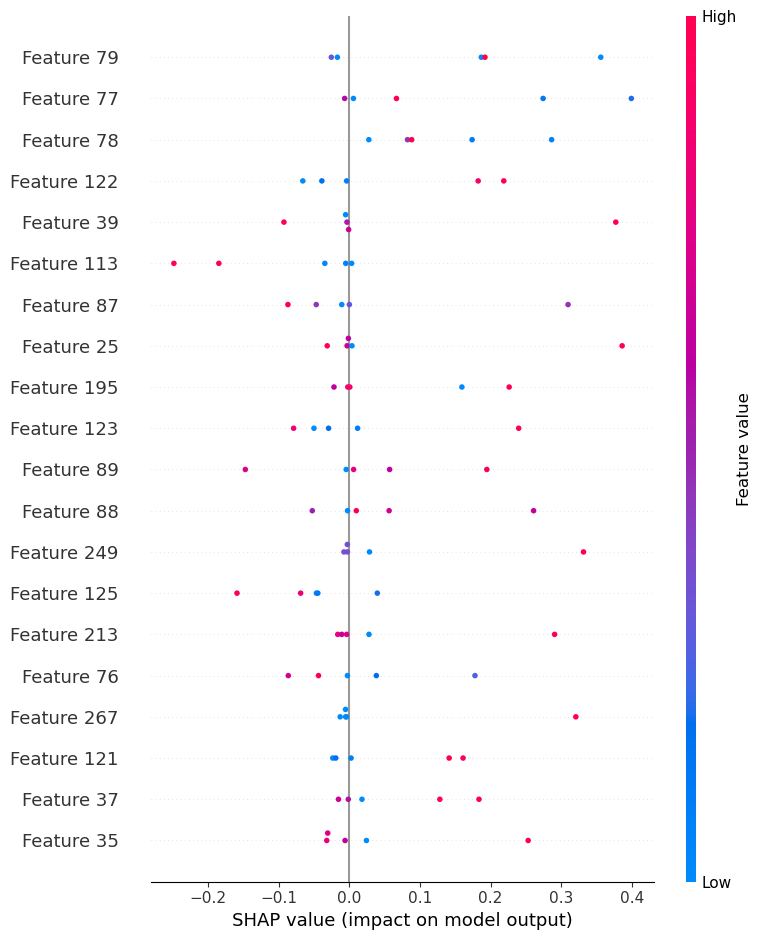

In [58]:
shap_values_bottom = explainer.shap_values(samples_bottom)
shap_flat_bottom = shap_values_bottom.reshape(shap_values_bottom.shape[0], -1)
test_flat_bottom = samples_bottom.reshape(samples_bottom.shape[0], -1)
shap.summary_plot(shap_flat_bottom, test_flat_bottom)

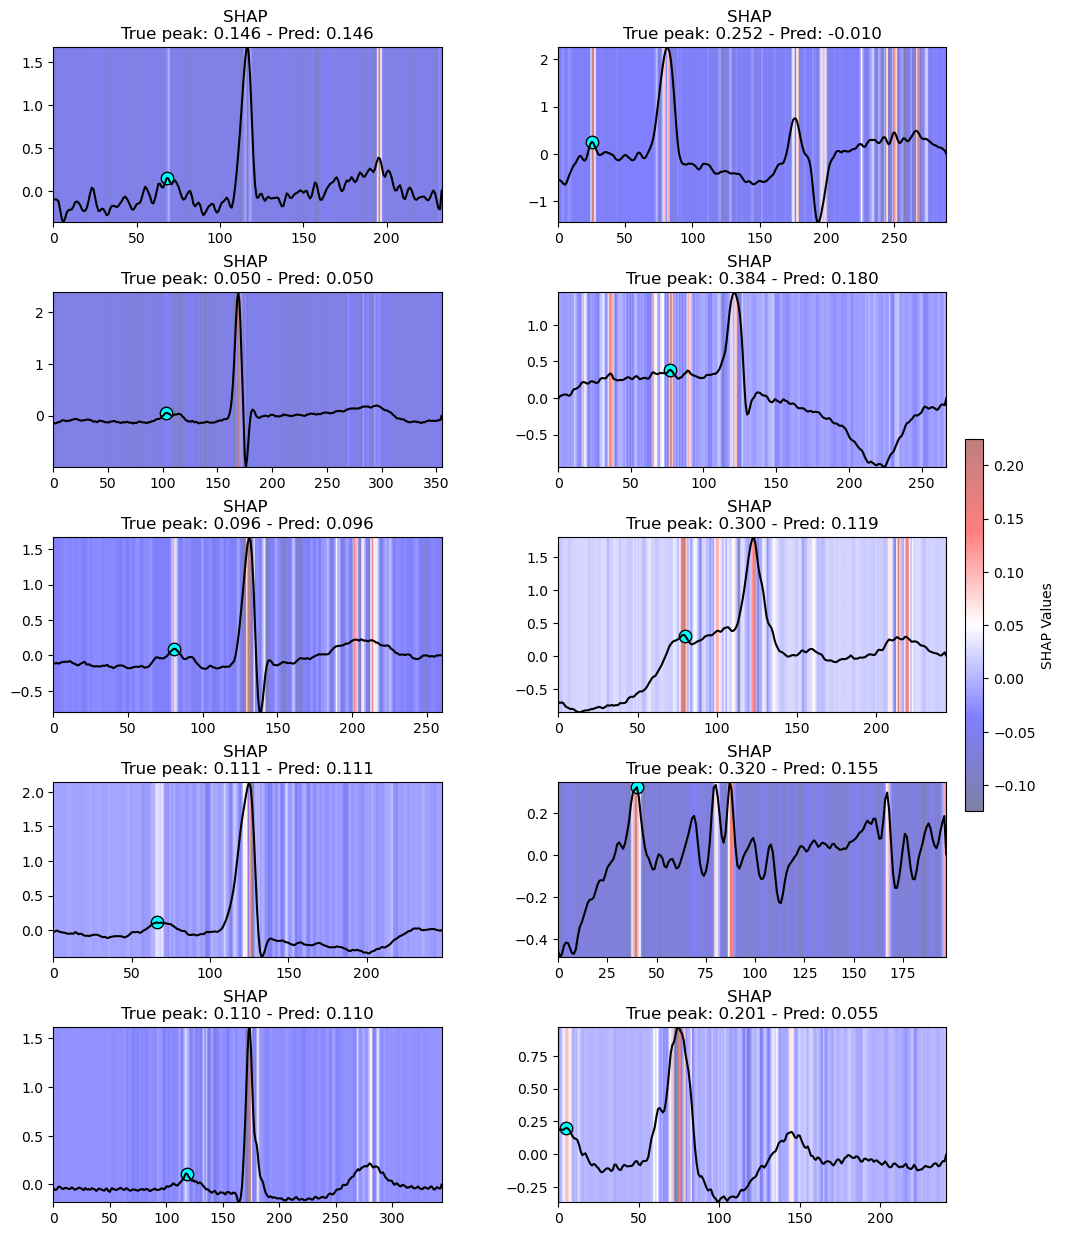

In [59]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

for i in range(len(samples)):
    importance = shap_values[i].flatten()
    
    ax = axes[i, 0]
    im = ax.imshow(
    np.vstack([importance, importance]), 
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :].min(), samples[i, :].max()],
    origin='lower') #plots saliency like a heatmap
    ax.plot(samples[i, :], color='black', label='ECG') #plots ECG signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    ax.set_title(f"SHAP \nTrue peak: {float(labels[i].item()):.3f} - Pred: {float(preds[i].item()):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

for i in range(len(samples_bottom)):
    importance = shap_values_bottom[i].flatten()
    
    ax = axes[i, 1]
    im = ax.imshow(
    np.vstack([importance, importance]), 
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :].min(), samples_bottom[i, :].max()],
    origin='lower') #plots saliency like a heatmap
    ax.plot(samples_bottom[i, :], color='black', label='ECG') #plots ECG signal
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    ax.set_title(f"SHAP \nTrue peak: {float(labels_bottom[i].item()):.3f} - Pred: {float(preds_bottom[i].item()):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i]) #cuts off at padding

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("SHAP Values")

### save pics

In [60]:
save_dir = "shap_best_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    importance = shap_values[i].flatten()
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([importance, importance]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_2d.shape[1], samples_2d[i, :].min(), samples_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"shap_best_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

In [61]:
save_dir = "shap_worst_images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(samples)):
    importance = shap_values_bottom[i].flatten()
    
    fig, ax = plt.subplots(figsize=(4, 3))  # each image its own figure
    
    # Heatmap overlay
    ax.imshow(
        np.vstack([importance, importance]), 
        cmap='seismic', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom_2d.shape[1], samples_bottom_2d[i, :].min(), samples_bottom_2d[i, :].max()],
        origin='lower')
    
    # ECG line
    ax.plot(samples_bottom_2d[i, :], color='black', label='ECG')
    
    # P-peaks
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_xlim(0, xlim_length_bottom[i])
    ax.axis("off")
    
    # Save image
    filename = os.path.join(save_dir, f"shap_worst_pred{i+1}.png")
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close(fig)

# AVG FOR PERTURB

### LIME

In [62]:
signals_top100_2d = np.squeeze(X_test[top100_idx])


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.squeeze(X_train),
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=False
)

lime_maps = np.zeros_like(signals_top100_2d)

In [63]:
for n, idx in enumerate(top100_idx):
    exp = explainer.explain_instance(signals_top100_2d[n], predict_fn, num_features=T, num_samples=5000)
    
    feat_weights = []
    for f, w in exp.as_list():
        f = int(f[1:])  # extract time index
        feat_weights.append((f, w))
    
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    weights = np.array(weights)
    
    lime_maps[n] = weights

157/157 [==============================] - 4s 24ms/step


In [64]:
aligned_lime = np.zeros_like(lime_maps)
for n, r_loc in enumerate(r_peaks):
    shift = center - r_loc
    aligned_lime[n] = np.roll(lime_maps[n], shift)

In [65]:
avg_lime_saliency = aligned_lime.mean(axis=0)

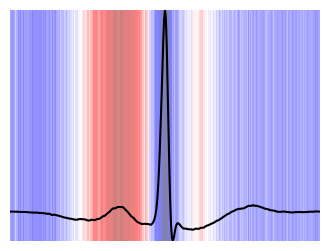

In [66]:
avg_aligned_signal = np.mean([
    np.roll(signals_top100[n], center - r_peaks[n]) for n in range(len(signals_top100))
], axis=0)

plt.figure(figsize=(4,3))
plt.imshow(
    np.vstack([avg_lime_saliency, avg_lime_saliency]),
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, len(avg_aligned_signal), avg_aligned_signal.min(), avg_aligned_signal.max()],
    origin='lower'
)
plt.plot(avg_aligned_signal, color='black')

plt.axis("off")
plt.savefig("Lime_avg_saliency", bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()

### dlime

In [67]:
T = signals_top100_2d.shape[1]
feature_names = [f"t{i}" for i in range(T)]

dlime_maps = np.zeros_like(signals_top100_2d)
for n in range(len(signals_top100_2d)):
    # Find cluster for this sample
    clust = knn.predict(signals_top100_2d[n].reshape(1, -1))[0]
    cluster_data = X_bg[cluster_labels == clust]

    # Local LIME on cluster data
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=cluster_data,
        feature_names=feature_names,
        mode='regression',
        discretize_continuous=False
    )
    exp = explainer.explain_instance(signals_top100_2d[n], predict_fn,
                                     num_features=358, num_samples=5000)
    
    feat_weights = [(int(f[1:]), w) for f, w in exp.as_list()]
    feat_weights.sort(key=lambda x: x[0])
    _, weights = zip(*feat_weights)
    dlime_maps[n] = np.array(weights)

157/157 [==============================] - 4s 24ms/step


In [68]:
aligned_dlime = np.zeros_like(dlime_maps)
for n, r_loc in enumerate(r_peaks):
    shift = center - r_loc
    aligned_dlime[n] = np.roll(dlime_maps[n], shift)

In [69]:
avg_dlime_saliency = aligned_dlime.mean(axis=0)

In [70]:
avg_aligned_signal = np.mean([
    np.roll(signals_top100_2d[n], center - r_peaks[n])
    for n in range(len(signals_top100))
], axis=0)

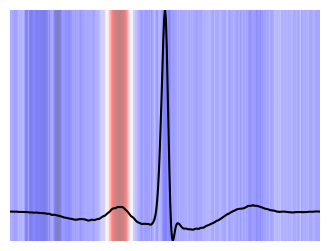

In [71]:
plt.figure(figsize=(4, 3))
plt.imshow(
    np.vstack([avg_dlime_saliency, avg_dlime_saliency]),
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, len(avg_aligned_signal), avg_aligned_signal.min(), avg_aligned_signal.max()],
    origin='lower'
)
plt.plot(avg_aligned_signal, color='black')
plt.axis("off")
plt.savefig("DLIME_avg_saliency.png", dpi=300, bbox_inches='tight')
plt.show()

### shap

In [72]:
background = X_train[:1000]
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(signals_top100)

shap_maps = np.zeros_like(signals_top100_2d)
for n in range(len(signals_top100_2d)):
    shap_maps[n] = shap_values[n].flatten()

/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [73]:
aligned_shap = np.zeros_like(shap_maps)
for n, r_loc in enumerate(r_peaks):
    shift = center - r_loc
    aligned_shap[n] = np.roll(shap_maps[n], shift)

In [74]:
avg_shap_saliency = aligned_shap.mean(axis=0)

In [75]:
avg_aligned_signal = np.mean([
    np.roll(signals_top100_2d[n], center - r_peaks[n])
    for n in range(len(signals_top100_2d))
], axis=0)

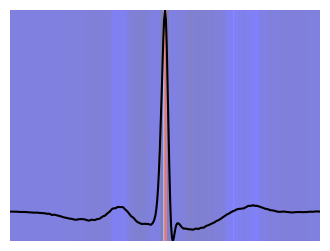

In [76]:
plt.figure(figsize=(4, 3))
plt.imshow(
    np.vstack([avg_shap_saliency, avg_shap_saliency]),
    cmap='seismic', aspect='auto', alpha=0.5,
    extent=[0, len(avg_aligned_signal), avg_aligned_signal.min(), avg_aligned_signal.max()],
    origin='lower'
)
plt.plot(avg_aligned_signal, color='black')
plt.axis("off")
plt.savefig("SHAP_avg_saliency.png", dpi=300, bbox_inches='tight')
plt.show()

# Print grid

### grid for preds

/tmp/ipykernel_105/4111377725.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[r, c].set_title(f"Best Prediction {c+1}\n True peak: {float(labels[c]):.3f}\nPredicted: {float(preds[c]):.3f}", fontsize=10)
/tmp/ipykernel_105/4111377725.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


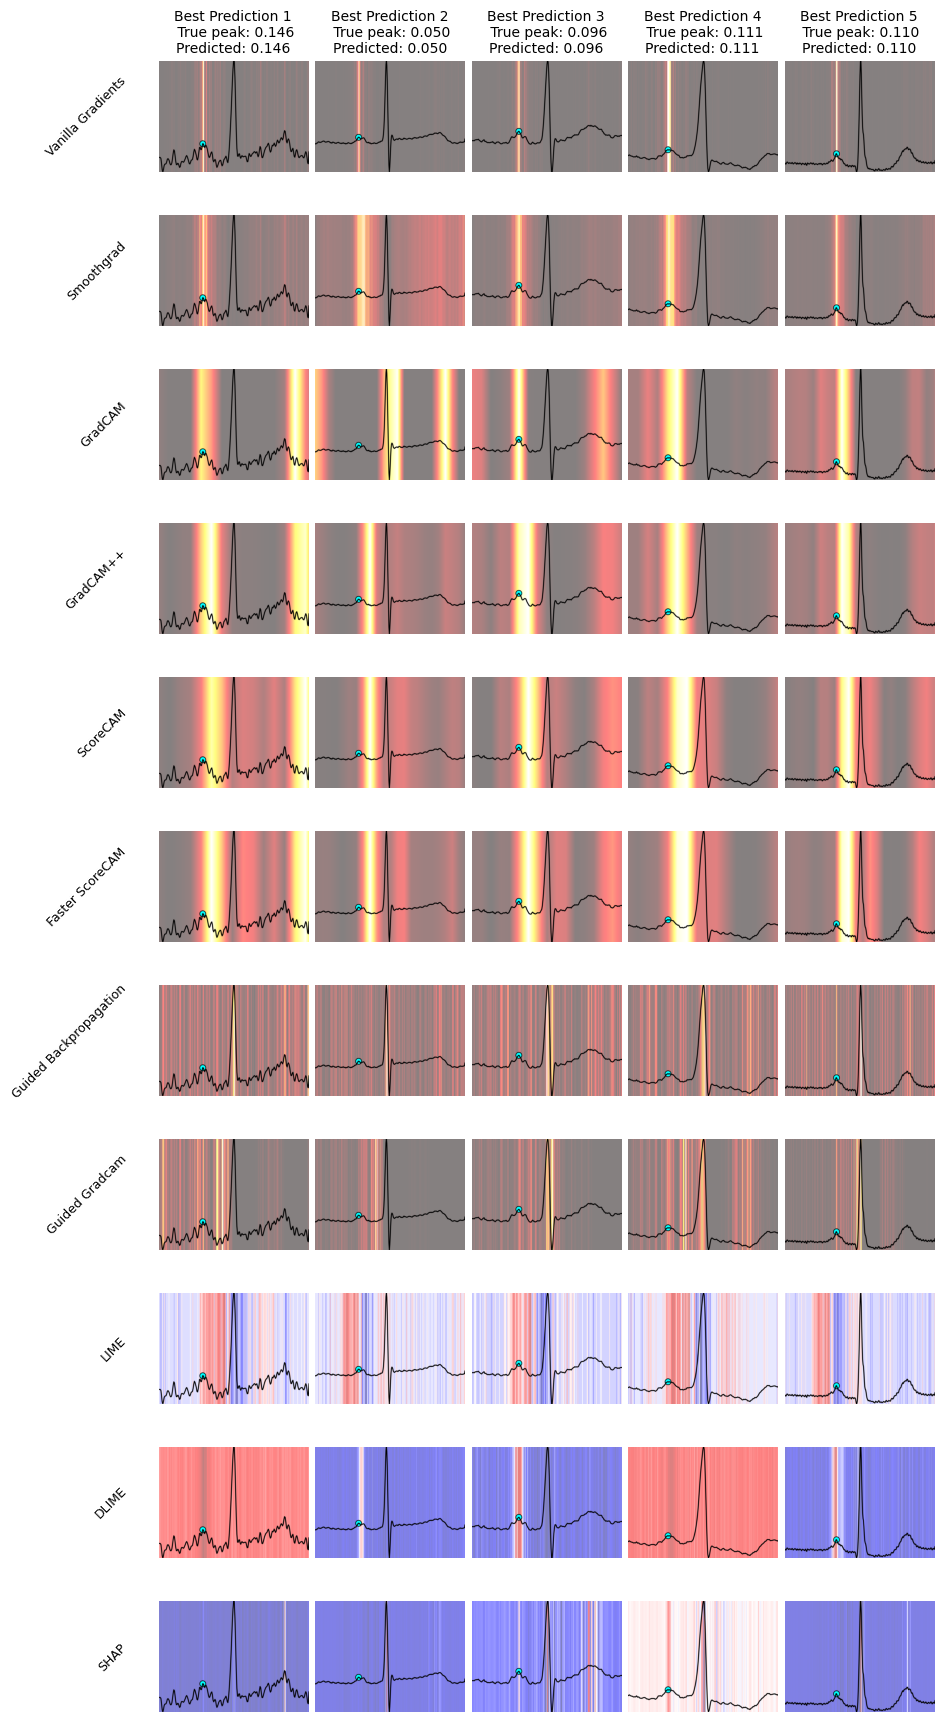

In [77]:
import matplotlib.pyplot as plt
import os
import cv2

# CONFIG
# -----------------
base_dir = "best_images"

method_for_plot = [
    "Vanilla Gradients", "Smoothgrad", "GradCAM", "GradCAM++", "ScoreCAM",
    "Faster ScoreCAM", "Guided Backpropagation", "Guided Gradcam",
    "LIME", "DLIME", "SHAP"
]

methods = ["vanilla", "sg", "GC", "GC++", "scorecam", "fastscorecam", "backprop", "guidedGC", "LIME", "Det_LIME", "shap"]


n_methods = len(methods)
n_preds = 5  # predictions 1–5


images = []
for method in methods:
    method_dir = os.path.join(base_dir, f"{method.replace(' ', '_')}_best_images")
    row_imgs = []
    for i in range(1, n_preds + 1):
        img_path = os.path.join(method_dir, f"{method.replace(' ', '_')}_best_pred{i}.png")
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        row_imgs.append(img)
    images.append(row_imgs)


fig, axes = plt.subplots(nrows=n_methods, ncols=n_preds,
                         figsize=(n_preds*2, n_methods*2),
                        gridspec_kw={"wspace": 0.05, "hspace": 0.0})

for r in range(n_methods):
    for c in range(n_preds):
        axes[r, c].imshow(images[r][c])
        axes[r, c].axis("off")
        
        
        # Column titles = Best pred labels
        if r == 0:
            axes[r, c].set_title(f"Best Prediction {c+1}\n True peak: {float(labels[c]):.3f}\nPredicted: {float(preds[c]):.3f}", fontsize=10)
        
        # Row labels = Method names
        if c == 0:
            axes[r, c].text(
                -0.2, 0.5, method_for_plot[r],
                fontsize=9, rotation=45, va="center", ha="right",
                transform=axes[r, c].transAxes
            )

plt.tight_layout()
plt.savefig("grid_best_preds.png", dpi=600, bbox_inches="tight")
plt.show()


NameError: name 'patches' is not defined

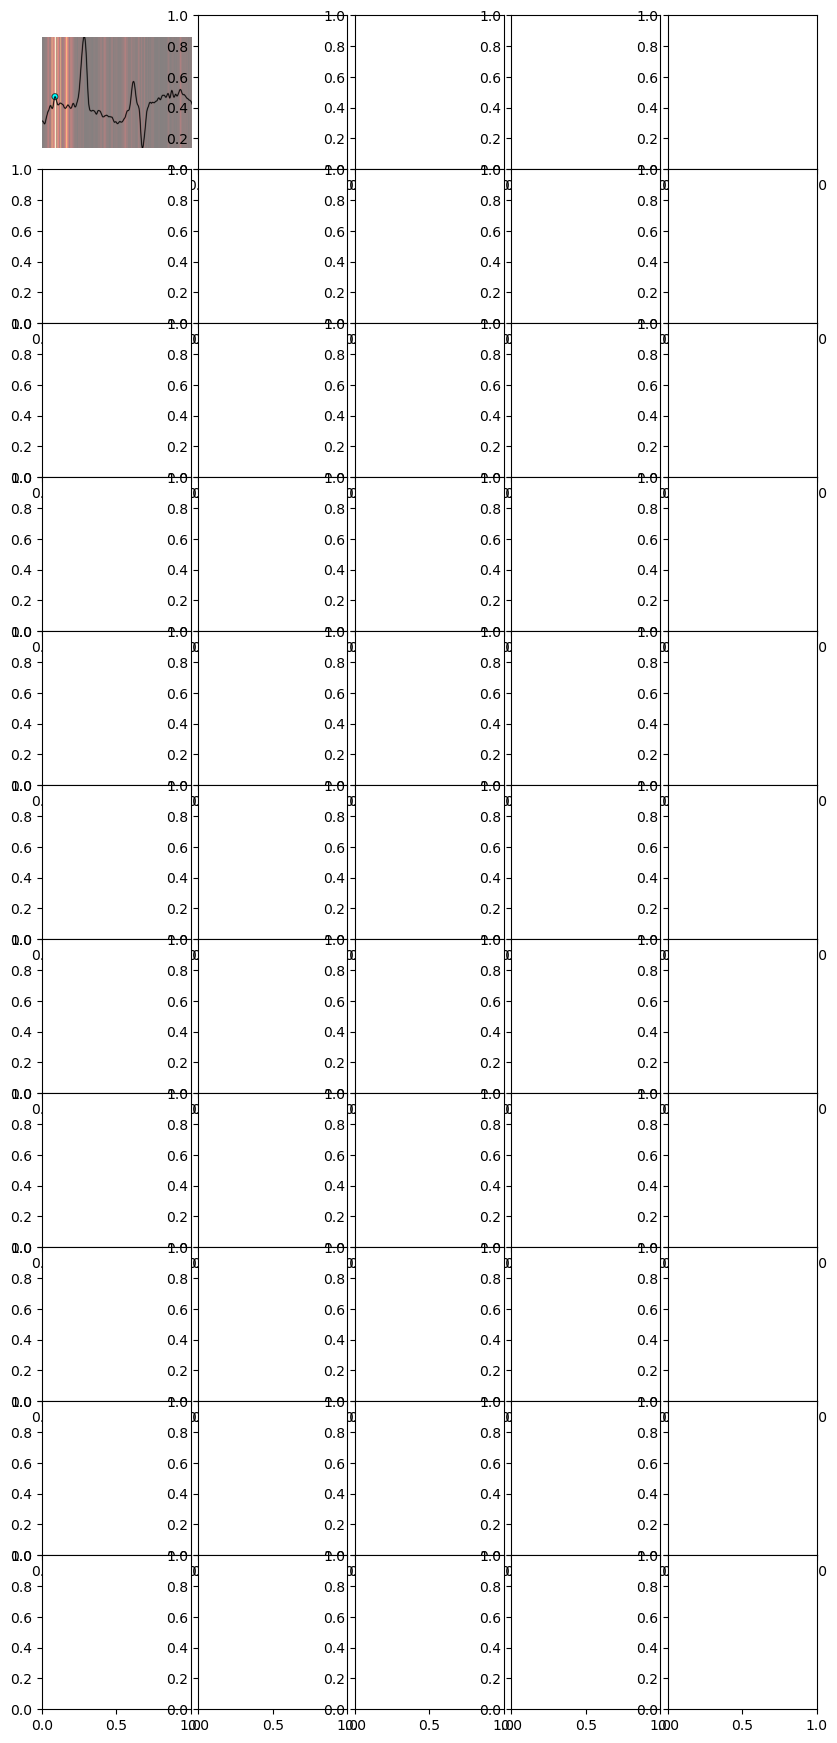

In [78]:
base_dir = "worst_images"

method_for_plot = [
    "Vanilla Gradients", "Smoothgrad", "GradCAM", "GradCAM++", "ScoreCAM",
    "Faster ScoreCAM", "Guided Backpropagation", "Guided Gradcam",
    "LIME", "DLIME", "SHAP"
]

methods = ["vanilla", "sg", "GC", "GC++", "scorecam", "fastscorecam", "backprop", "guidedGC", "LIME", "det_LIME", "shap"]


n_methods = len(methods)
n_preds = 5  # predictions 1–5

# -----------------
# Load all images
# -----------------
# images[row=method][col=prediction]
images = []
for method in methods:
    method_dir = os.path.join(base_dir, f"{method.replace(' ', '_')}_worst_images")
    row_imgs = []
    for i in range(1, n_preds + 1):
        img_path = os.path.join(method_dir, f"{method.replace(' ', '_')}_worst_pred{i}.png")
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        row_imgs.append(img)
    images.append(row_imgs)

# -----------------
# Plot the grid
# -----------------
fig, axes = plt.subplots(nrows=n_methods, ncols=n_preds,
                         figsize=(n_preds*2, n_methods*2),
                        gridspec_kw={"wspace": 0.05, "hspace": 0.0})

for r in range(n_methods):
    for c in range(n_preds):
        axes[r, c].imshow(images[r][c])
        axes[r, c].axis("off")

        rect = patches.Rectangle(
            (0, 0),  # bottom-left corner
            1, 1,    # width & height in axis coordinates
            linewidth=5,
            edgecolor="black",
            facecolor="none",
            transform=axes[r,c].transAxes
        )
        axes[r,c].add_patch(rect)
        
        # Column titles = Best pred labels
        if r == 0:
            axes[r, c].set_title(f"Worst Prediction {c+1}\n True Peak: {float(labels_bottom[c]):.3f}\nPredicted: {float(preds_bottom[c]):.3f}", fontsize=10)
        
        # Row labels = Method names
        if c == 0:
            axes[r, c].text(
                -0.2, 0.5, method_for_plot[r],
                fontsize=9, rotation=0, va="center", ha="right",
                transform=axes[r, c].transAxes
            )

plt.tight_layout()
plt.savefig("worst_preds-With_borders.png", dpi=600, bbox_inches="tight")
plt.show()


### grid for avg

In [ ]:
import matplotlib.patches as patches
base_dir = "best_images"
avg_dir = "average_saliency_images"

method_for_plot = [
    "Vanilla Gradients", "Smoothgrad", "GradCAM", "GradCAM++", "ScoreCAM",
    "Faster ScoreCAM", "Guided Backpropagation", "Guided Gradcam",
    "LIME", "DLIME", "SHAP"
]

methods = ["vanilla", "sg", "GC", "GC++", "scorecam", "fastscorecam", "backprop", "guidedGC", "LIME", "Det_LIME", "shap"]
methods_avg = ["Vanilla", "SmoothGrad", "GradCam", "GradCamPlus", "ScoreCam", "FasterScoreCam", "GuidedBackPropagation", "GuidedGradCam", "Lime", "DLIME", "SHAP"]

n_methods = len(methods)
n_preds = 5  # predictions 1–5
n_cols = n_preds + 1

images = []
for m, method in enumerate(methods):
    method_dir = os.path.join(base_dir, f"{method.replace(' ', '_')}_best_images")
    avg_img_path = os.path.join(avg_dir, f"{methods_avg[m].replace(' ', '_')}_avg_saliency.png")
    
    row_imgs = []
    for i in range(1, n_preds + 1):
        img_path = os.path.join(method_dir, f"{method.replace(' ', '_')}_best_pred{i}.png")
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        row_imgs.append(img)

    avg_img = cv2.imread(avg_img_path)
    if avg_img is None:
        raise FileNotFoundError(f"Average saliency image not found: {avg_img_path}")
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
    row_imgs.append(avg_img)
    
    images.append(row_imgs)


fig, axes = plt.subplots(nrows=n_methods, ncols=n_cols,
                         figsize=(n_preds*2, n_methods*2),
                        gridspec_kw={"wspace": 0.05, "hspace": 0.0})

for r in range(n_methods):
    for c in range(n_cols):
        axes[r, c].imshow(images[r][c])
        axes[r, c].axis("off")

        rect = patches.Rectangle(
            (0, 0),  # bottom-left corner
            1, 1,    # width & height in axis coordinates
            linewidth=5,
            edgecolor="black",
            facecolor="none",
            transform=axes[r,c].transAxes
        )
        axes[r,c].add_patch(rect)
        
        # Column titles = Best pred labels
        if r == 0:
            if c < n_preds:
                axes[r, c].set_title(f"Best Prediction {c+1}\n True peak: {float(labels[c]):.3f}\nPredicted: {float(preds[c]):.3f}", fontsize=10)
            else:
                axes[r, c].set_title("Average Saliency\nFor Top 100\nPredictions", fontsize=10)
        
        # Row labels = Method names
        if c == 0:
            axes[r, c].text(
                -0.2, 0.5, method_for_plot[r],
                fontsize=9, rotation=45, va="center", ha="right",
                transform=axes[r, c].transAxes
            )

plt.tight_layout()
plt.savefig("all_grid_with_borders.png", dpi=600, bbox_inches="tight")
plt.show()


# QUANTITATIVE

### quant functions

In [79]:
def validate_saliency(model, X, y, saliency_maps, top_k_percent=10):
    # get original performance
    original_pred = model.predict(X)
    original_mse = mean_squared_error(y, original_pred)
    original_mae = mean_absolute_error(y, original_pred)
    
    # Calculate how many features to delete
    n_timepoints = X.shape[1] 
    n_delete = int((top_k_percent / 100) * n_timepoints)

    print(f"Original MSE: {original_mse:.4f}  Original MAE: {original_mae:.4f}")
    print(f"Deleting top {top_k_percent}% ({n_delete}) most salient features...")

    X_masked = X.copy()

    for i in range(len(X)):
        # Get saliency scores for this sample
        scores = saliency_maps[i, :]  # Shape: (358,)
        
        # Find indices of most important features
        top_indices = np.argsort(scores)[-n_delete:]  # Most salient
        
        # Delete by setting to zero
        X_masked[i, top_indices, 0] = 0

    # Get performance after deletion
    masked_pred = model.predict(X_masked)
    masked_mse = mean_squared_error(y, masked_pred)
    masked_mae = mean_absolute_error(y, masked_pred)


    # Calculate performance drop
    performance_drop_mse = masked_mse - original_mse
    performance_drop_mae = masked_mae - original_mae

    relative_drop_mse = (performance_drop_mse / original_mse) * 100
    relative_drop_mae = (performance_drop_mae / original_mae) * 100


    print(f"MSE after deletion: {masked_mse:.4f}  MAE after deletion: {masked_mae:.4f}")
    print(f"Performance drop in MSE: {performance_drop_mse:.4f} ({relative_drop_mse:.1f}%)")
    print(f"Performance drop in MAE: {performance_drop_mae:.4f} ({relative_drop_mae:.1f}%)")


    return {
        'original_mse': original_mse,
        'masked_mse': masked_mse,
        'original_mae': original_mae,
        'masked_mae': masked_mae, 
        'performance_drop(MSE)': performance_drop_mse,
        'performance_drop(MAE)': performance_drop_mae,
        'relative_drop_percent(MSE)': relative_drop_mse,
        'relative_drop_percent(MAE)': relative_drop_mae
    }

In [80]:
def compare_deletion_strategies(model, X, y, saliency_maps, top_k_percent=10):
    """
    Compare deleting most important vs least important vs random features.
    """
    n_timepoints = X.shape[1]
    n_delete = int((top_k_percent / 100) * n_timepoints)

    # Original performance
    original_pred = model.predict(X)
    original_mse = mean_squared_error(y, original_pred)
    original_mae = mean_absolute_error(y, original_pred)

    print(f"Original MSE: {original_mse:.4f}  Original MAE: {original_mae:.4f}")
    print(f"Deleting top {top_k_percent}% ({n_delete}) most salient features...")
    
    results = {'original_mse': original_mse,
              'original_mae': original_mae
              }
    strategies = ['most_important', 'least_important', 'random']

    for strategy in strategies:
        X_masked = X.copy()

        for i in range(len(X)):
            scores = saliency_maps[i, :]
            
            if strategy == 'most_important':
                indices = np.argsort(scores)[-n_delete:]  # Top salient
            elif strategy == 'least_important': 
                indices = np.argsort(scores)[:n_delete]   # Least salient
            else:  # random
                indices = np.random.choice(n_timepoints, n_delete, replace=False)
            
            X_masked[i, indices, 0] = 0

        pred = model.predict(X_masked)
        mse = mean_squared_error(y, pred)
        mae = mean_absolute_error(y, pred)
        
        drop_mse = mse - original_mse
        drop_mae = mae - original_mae
        
        relative_drop_mse = (drop_mse / original_mse) * 100
        relative_drop_mae = (drop_mae / original_mae) * 100

        results[f'{strategy}_mse'] = mse
        results[f'{strategy}_mae'] = mae
        
        results[f'{strategy}_drop(mse)'] = drop_mse
        results[f'{strategy}_drop(mae)'] = drop_mae
        
        print(f"{strategy.replace('_', ' ').title()}: MSE = {mse:.4f}, MAE = {mae:.4f}\n      Drop(MSE) = {drop_mse:.4f}({relative_drop_mse:.1f}%)  Drop(MAE) = {drop_mae:.4f}({relative_drop_mae:.1f}%)")
    
    return results

In [81]:
def display_comparison_table(comparison_results):
    """
    Display comparison results in a table sorted by MSE performance drop (descending).
    
    Parameters:
    -----------
    comparison_results : dict
        Results from compare_deletion_strategies function
    """
    
    # Extract data for table
    strategies = ['most_important', 'least_important', 'random']
    table_data = []
    
    original_mse = comparison_results['original_mse']
    original_mae = comparison_results['original_mae']
    
    for strategy in strategies:
        mse = comparison_results[f'{strategy}_mse']
        mae = comparison_results[f'{strategy}_mae']
        drop_mse = comparison_results[f'{strategy}_drop(mse)']
        drop_mae = comparison_results[f'{strategy}_drop(mae)']
        
        relative_drop_mse = (drop_mse / original_mse) * 100
        relative_drop_mae = (drop_mae / original_mae) * 100
        
        table_data.append({
            'Strategy': strategy.replace('_', ' ').title(),
            'MSE': f"{mse:.4f}",
            'MAE': f"{mae:.4f}",
            'MSE Drop': f"{drop_mse:.4f}",
            'MAE Drop': f"{drop_mae:.4f}",
            'MSE Drop (%)': f"{relative_drop_mse:.1f}%",
            'MAE Drop (%)': f"{relative_drop_mae:.1f}%"
        })
    
    # Create DataFrame and sort by MSE performance drop (descending)
    df = pd.DataFrame(table_data)
    df['drop_mse_numeric'] = [comparison_results[f'{strategy}_drop(mse)'] for strategy in strategies]
    df = df.sort_values('drop_mse_numeric', ascending=False).drop('drop_mse_numeric', axis=1)
    
    # Display table
    print(f"Original MSE: {original_mse:.4f}  |  Original MAE: {original_mae:.4f}")
    print("\nSaliency Validation Results (sorted by MSE performance drop):")
    print("=" * 90)
    print(df.to_string(index=False))
    print("=" * 90)
    
    # Interpretation
    print("\nInterpretation:")
    if df.iloc[0]['Strategy'] == 'Most Important':
        print("✅ GOOD: Most important features cause largest performance drop")
        print("   Your saliency maps correctly identify important features!")
    else:
        print("⚠️  WARNING: Most important features don't cause largest drop")
        print("   Your saliency maps may not be capturing meaningful patterns")
    
    return df

In [82]:
top1000_idx = np.argsort(errors)[:1000]
samples_top1000 = np.stack([X_test[i] for i in top1000_idx])
labels_top1000 = np.stack([y_test[i] for i in top1000_idx])

### Vanilla saliency quant

In [83]:
vanilla_saliency_map_top1000 = van_saliency(score, samples_top1000)

In [84]:
vanilla_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=vanilla_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 24ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 25ms/step
MSE after deletion: 0.0037  MAE after deletion: 0.0485
Performance drop in MSE: 0.0037 (1008171.1%)
Performance drop in MAE: 0.0480 (9168.5%)


In [85]:
vanilla_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, vanilla_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 26ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 23ms/step
Most Important: MSE = 0.0021, MAE = 0.0358
      Drop(MSE) = 0.0021(571074.6%)  Drop(MAE) = 0.0353(6741.1%)
32/32 [==============================] - 1s 22ms/step
Least Important: MSE = 0.0000, MAE = 0.0023
      Drop(MSE) = 0.0000(8511.9%)  Drop(MAE) = 0.0018(335.2%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0002, MAE = 0.0073
      Drop(MSE) = 0.0002(45375.1%)  Drop(MAE) = 0.0068(1296.8%)


In [86]:
display_comparison_table(vanilla_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0021 0.0358   0.0021   0.0353    571074.6%      6741.1%
         Random 0.0002 0.0073   0.0002   0.0068     45375.1%      1296.8%
Least Important 0.0000 0.0023   0.0000   0.0018      8511.9%       335.2%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0021  0.0358   0.0021   0.0353    571074.6%      6741.1%
2           Random  0.0002  0.0073   0.0002   0.0068     45375.1%      1296.8%
1  Least Important  0.0000  0.0023   0.0000   0.0018      8511.9%       335.2%

### Smoothgrad quant

In [87]:
sg_saliency_map_top1000 = sg_saliency(score, samples_top1000)

In [88]:
sg_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=sg_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 26ms/step
MSE after deletion: 0.0037  MAE after deletion: 0.0485
Performance drop in MSE: 0.0037 (1008171.1%)
Performance drop in MAE: 0.0480 (9168.5%)


In [89]:
sg_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, sg_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 24ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 25ms/step
Most Important: MSE = 0.0021, MAE = 0.0358
      Drop(MSE) = 0.0021(571074.6%)  Drop(MAE) = 0.0353(6741.1%)
32/32 [==============================] - 1s 23ms/step
Least Important: MSE = 0.0000, MAE = 0.0023
      Drop(MSE) = 0.0000(8511.9%)  Drop(MAE) = 0.0018(335.2%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0002, MAE = 0.0075
      Drop(MSE) = 0.0002(45408.3%)  Drop(MAE) = 0.0070(1338.1%)


In [90]:
display_comparison_table(sg_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0021 0.0358   0.0021   0.0353    571074.6%      6741.1%
         Random 0.0002 0.0075   0.0002   0.0070     45408.3%      1338.1%
Least Important 0.0000 0.0023   0.0000   0.0018      8511.9%       335.2%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0021  0.0358   0.0021   0.0353    571074.6%      6741.1%
2           Random  0.0002  0.0075   0.0002   0.0070     45408.3%      1338.1%
1  Least Important  0.0000  0.0023   0.0000   0.0018      8511.9%       335.2%

### GradCAM quant

In [91]:
gradcam_saliency_map_top1000 = gradcam(score, samples_top1000, penultimate_layer= penultimate_layer)

In [92]:
gradcam_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=gradcam_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 25ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 23ms/step
MSE after deletion: 0.0032  MAE after deletion: 0.0386
Performance drop in MSE: 0.0032 (870423.2%)
Performance drop in MAE: 0.0380 (7269.5%)


In [93]:
gradcam_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, gradcam_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 23ms/step
Most Important: MSE = 0.0004, MAE = 0.0085
      Drop(MSE) = 0.0004(110441.3%)  Drop(MAE) = 0.0079(1517.3%)
32/32 [==============================] - 1s 23ms/step
Least Important: MSE = 0.0002, MAE = 0.0046
      Drop(MSE) = 0.0002(59674.0%)  Drop(MAE) = 0.0041(781.1%)
32/32 [==============================] - 1s 22ms/step
Random: MSE = 0.0002, MAE = 0.0076
      Drop(MSE) = 0.0002(44185.6%)  Drop(MAE) = 0.0071(1347.9%)


In [94]:
display_comparison_table(gradcam_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0004 0.0085   0.0004   0.0079    110441.3%      1517.3%
Least Important 0.0002 0.0046   0.0002   0.0041     59674.0%       781.1%
         Random 0.0002 0.0076   0.0002   0.0071     44185.6%      1347.9%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0004  0.0085   0.0004   0.0079    110441.3%      1517.3%
1  Least Important  0.0002  0.0046   0.0002   0.0041     59674.0%       781.1%
2           Random  0.0002  0.0076   0.0002   0.0071     44185.6%      1347.9%

### gradCAM ++ quant

In [95]:
gradcam_plus_saliency_map_top1000 = gradcam_plus(score, samples_top1000, penultimate_layer= penultimate_layer)

In [96]:
gradcam_plus_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=gradcam_plus_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 25ms/step
MSE after deletion: 0.0019  MAE after deletion: 0.0284
Performance drop in MSE: 0.0019 (510500.7%)
Performance drop in MAE: 0.0279 (5336.3%)


In [97]:
gradcam_plus_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, gradcam_plus_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 24ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 23ms/step
Most Important: MSE = 0.0002, MAE = 0.0076
      Drop(MSE) = 0.0002(67610.5%)  Drop(MAE) = 0.0071(1361.3%)
32/32 [==============================] - 1s 19ms/step
Least Important: MSE = 0.0000, MAE = 0.0019
      Drop(MSE) = 0.0000(4092.7%)  Drop(MAE) = 0.0014(269.9%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0001, MAE = 0.0071
      Drop(MSE) = 0.0001(37255.7%)  Drop(MAE) = 0.0066(1253.3%)


In [98]:
display_comparison_table(gradcam_plus_comparison)


Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0002 0.0076   0.0002   0.0071     67610.5%      1361.3%
         Random 0.0001 0.0071   0.0001   0.0066     37255.7%      1253.3%
Least Important 0.0000 0.0019   0.0000   0.0014      4092.7%       269.9%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0002  0.0076   0.0002   0.0071     67610.5%      1361.3%
2           Random  0.0001  0.0071   0.0001   0.0066     37255.7%      1253.3%
1  Least Important  0.0000  0.0019   0.0000   0.0014      4092.7%       269.9%

### Scorecam quant

In [99]:
scorecam_saliency_map_top1000 = scorecam(score, samples_top1000, penultimate_layer= penultimate_layer)

8000/8000 [==============================] - 193s 24ms/step


In [100]:
scorecam_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=scorecam_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 25ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 23ms/step
MSE after deletion: 0.0035  MAE after deletion: 0.0444
Performance drop in MSE: 0.0035 (962767.6%)
Performance drop in MAE: 0.0439 (8393.9%)


In [101]:
scorecam_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, scorecam_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 22ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 22ms/step
Most Important: MSE = 0.0001, MAE = 0.0038
      Drop(MSE) = 0.0001(27085.4%)  Drop(MAE) = 0.0032(620.0%)
32/32 [==============================] - 1s 24ms/step
Least Important: MSE = 0.0001, MAE = 0.0035
      Drop(MSE) = 0.0001(22092.2%)  Drop(MAE) = 0.0030(577.2%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0002, MAE = 0.0075
      Drop(MSE) = 0.0002(47896.5%)  Drop(MAE) = 0.0070(1332.1%)


In [102]:
display_comparison_table(scorecam_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
         Random 0.0002 0.0075   0.0002   0.0070     47896.5%      1332.1%
 Most Important 0.0001 0.0038   0.0001   0.0032     27085.4%       620.0%
Least Important 0.0001 0.0035   0.0001   0.0030     22092.2%       577.2%

Interpretation:
⚠️  WARNING: Most important features don't cause largest drop
   Your saliency maps may not be capturing meaningful patterns


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
2           Random  0.0002  0.0075   0.0002   0.0070     47896.5%      1332.1%
0   Most Important  0.0001  0.0038   0.0001   0.0032     27085.4%       620.0%
1  Least Important  0.0001  0.0035   0.0001   0.0030     22092.2%       577.2%

### Faster scorecame quant

In [103]:
faster_scorecam_saliency_map_top1000 = scorecam(score, samples_top1000, penultimate_layer= penultimate_layer, max_N=10)

2282/2282 [==============================] - 55s 24ms/step


In [104]:
faster_scorecam_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=scorecam_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 22ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 23ms/step
MSE after deletion: 0.0035  MAE after deletion: 0.0444
Performance drop in MSE: 0.0035 (962767.6%)
Performance drop in MAE: 0.0439 (8393.9%)


In [105]:
faster_scorecam_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, faster_scorecam_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 22ms/step
Most Important: MSE = 0.0005, MAE = 0.0117
      Drop(MSE) = 0.0005(127226.1%)  Drop(MAE) = 0.0112(2141.3%)
32/32 [==============================] - 1s 23ms/step
Least Important: MSE = 0.0001, MAE = 0.0033
      Drop(MSE) = 0.0001(16672.4%)  Drop(MAE) = 0.0027(524.9%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0002, MAE = 0.0077
      Drop(MSE) = 0.0002(51931.7%)  Drop(MAE) = 0.0072(1371.1%)


In [106]:
display_comparison_table(faster_scorecam_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0005 0.0117   0.0005   0.0112    127226.1%      2141.3%
         Random 0.0002 0.0077   0.0002   0.0072     51931.7%      1371.1%
Least Important 0.0001 0.0033   0.0001   0.0027     16672.4%       524.9%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0005  0.0117   0.0005   0.0112    127226.1%      2141.3%
2           Random  0.0002  0.0077   0.0002   0.0072     51931.7%      1371.1%
1  Least Important  0.0001  0.0033   0.0001   0.0027     16672.4%       524.9%

### guided backprop quant

In [107]:
gb_saliency_map_top1000 = gb_saliency(score, samples_top1000)

In [108]:
gb_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=gb_saliency_map_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 21ms/step
MSE after deletion: 0.0052  MAE after deletion: 0.0570
Performance drop in MSE: 0.0052 (1426754.5%)
Performance drop in MAE: 0.0565 (10788.9%)


In [109]:
gb_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, gb_saliency_map_top1000, top_k_percent=10)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 22ms/step
Most Important: MSE = 0.0035, MAE = 0.0455
      Drop(MSE) = 0.0035(960425.6%)  Drop(MAE) = 0.0450(8590.7%)
32/32 [==============================] - 1s 23ms/step
Least Important: MSE = 0.0000, MAE = 0.0019
      Drop(MSE) = 0.0000(6104.9%)  Drop(MAE) = 0.0014(269.7%)
32/32 [==============================] - 1s 23ms/step
Random: MSE = 0.0002, MAE = 0.0079
      Drop(MSE) = 0.0002(52320.1%)  Drop(MAE) = 0.0074(1408.4%)


In [110]:
display_comparison_table(gb_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0035 0.0455   0.0035   0.0450    960425.6%      8590.7%
         Random 0.0002 0.0079   0.0002   0.0074     52320.1%      1408.4%
Least Important 0.0000 0.0019   0.0000   0.0014      6104.9%       269.7%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0035  0.0455   0.0035   0.0450    960425.6%      8590.7%
2           Random  0.0002  0.0079   0.0002   0.0074     52320.1%      1408.4%
1  Least Important  0.0000  0.0019   0.0000   0.0014      6104.9%       269.7%

### guided grad cam quant

In [111]:
cam_resized_guided_grad = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in gradcam_saliency_map_top1000
])
guided_gradcam_top1000 = gb_saliency_map_top1000 * cam_resized_guided_grad

In [112]:
guided_gradcam_results = validate_saliency(
    model = model,
    X=samples_top1000, 
    y=labels_top1000,
    saliency_maps=guided_gradcam_top1000,
    top_k_percent=20
)

32/32 [==============================] - 1s 22ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 20% (71) most salient features...
32/32 [==============================] - 1s 22ms/step
MSE after deletion: 0.0043  MAE after deletion: 0.0447
Performance drop in MSE: 0.0043 (1187867.8%)
Performance drop in MAE: 0.0442 (8446.7%)


In [113]:
guided_gradcam_comparison = compare_deletion_strategies(model, samples_top1000, labels_top1000, guided_gradcam_top1000, top_k_percent=10)

32/32 [==============================] - 1s 23ms/step
Original MSE: 0.0000  Original MAE: 0.0005
Deleting top 10% (35) most salient features...
32/32 [==============================] - 1s 21ms/step
Most Important: MSE = 0.0028, MAE = 0.0339
      Drop(MSE) = 0.0028(770518.4%)  Drop(MAE) = 0.0334(6374.5%)
32/32 [==============================] - 1s 23ms/step
Least Important: MSE = 0.0001, MAE = 0.0026
      Drop(MSE) = 0.0001(24175.5%)  Drop(MAE) = 0.0020(390.4%)
32/32 [==============================] - 1s 22ms/step
Random: MSE = 0.0002, MAE = 0.0079
      Drop(MSE) = 0.0002(47774.4%)  Drop(MAE) = 0.0073(1400.5%)


In [114]:
display_comparison_table(guided_gradcam_comparison)

Original MSE: 0.0000  |  Original MAE: 0.0005

Saliency Validation Results (sorted by MSE performance drop):
       Strategy    MSE    MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
 Most Important 0.0028 0.0339   0.0028   0.0334    770518.4%      6374.5%
         Random 0.0002 0.0079   0.0002   0.0073     47774.4%      1400.5%
Least Important 0.0001 0.0026   0.0001   0.0020     24175.5%       390.4%

Interpretation:
✅ GOOD: Most important features cause largest performance drop
   Your saliency maps correctly identify important features!


Strategy     MSE     MAE MSE Drop MAE Drop MSE Drop (%) MAE Drop (%)
0   Most Important  0.0028  0.0339   0.0028   0.0334    770518.4%      6374.5%
2           Random  0.0002  0.0079   0.0002   0.0073     47774.4%      1400.5%
1  Least Important  0.0001  0.0026   0.0001   0.0020     24175.5%       390.4%

### LIME quant

In [115]:
def mask_regions(sample, regions_to_mask, mask_value=0):
    # sample: numpy array (e.g., image or feature vector)
    # regions_to_mask: list of indices or boolean masks identifying regions to mask
    masked_sample = sample.copy()
    for region in regions_to_mask:
        # Apply masking. The exact masking depends on how regions are represented.
        # Example: if region is a list of pixel indices:
        masked_sample[region] = mask_value
    return masked_sample

mse_drop = {'top_10%': [], 'random_10%': [], 'bottom_10%': []}
mae_drop = {'top_10%': [], 'random_10%': [], 'bottom_10%': []}

for i in range(100):
    sample = signals_top100_2d[i]
    true_label = labels_top100[i]

    explanation = explainer.explain_instance(sample, predict_fn, num_features=358, num_samples=5000)
    # Get importance: list of (region_id, importance_score)
    importances = explanation.local_exp[1]  # for regression task
    
    # Sort by importance descending
    sorted_regions = sorted(importances, key=lambda x: x[1], reverse=True)
    
    n_remove = int(0.1 * len(sorted_regions))  # 10% regions
    
    top_regions = [r[0] for r in sorted_regions[:n_remove]]
    bottom_regions = [r[0] for r in sorted_regions[-n_remove:]]
    random_regions = np.random.choice([r[0] for r in sorted_regions], n_remove, replace=False)
    
    # Original prediction
    original_pred = model.predict(sample.reshape(1, -1))
    
    for group, regions_to_remove in zip(['top_10%', 'random_10%', 'bottom_10%'],
                                       [top_regions, random_regions, bottom_regions]):
        masked_sample = mask_regions(sample, regions_to_remove)
        new_pred = model.predict(masked_sample.reshape(1, -1))
        
        mse_drop[group].append(mean_squared_error([true_label], new_pred))
        mae_drop[group].append(mean_absolute_error([true_label], new_pred))

# After loop, analyze mean drops
for group in mse_drop:
    print(f"{group}: MSE={np.mean(mse_drop[group])}, MAE={np.mean(mae_drop[group])}")


AttributeError: 'GradientExplainer' object has no attribute 'explain_instance'

# code below does not work

## DEEP LIFT

In [ ]:
# # pip install deeplift
# from deeplift.layers import NonlinearMxtsMode
# from deeplift.conversion import kerasapi_conversion as kc

# # Convert Keras model to DeepLift
# deeplift_model = kc.convert_model_from_saved_files(
#     'ecg_model.h5', 
#     nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT_GenomicsDefault
# )



# # Get importance scores
# baseline = np.zeros((1, 358, 1))
# scores = deeplift_model.get_target_contribs_func(
#     find_scores_layer_idx=0,
#     target_layer_idx=-1
# )

# attributions = scores(task_idx=0, input_data_list=[test_samples], 
#                      input_references_list=[baseline])

In [ ]:
stop

## IG

In [ ]:
# example = X_test[0:1]

# preds = model.predict(example)
# target_class = np.argmax(preds[0])

# ig = IntegratedGradients()
# baseline = np.zeros_like(example)

# attributions = ig.explain(
#     validation_data=(example, None),
#     model=model,
#     class_index=target_class,
#     n_steps=50
# )

# signal = example.squeeze()
# attr = attributions.squeeze()


# plt.figure(figsize=(10, 4))
# plt.plot(signal, label='ECG Signal')
# plt.plot(attr,   label='Integrated Gradients')
# plt.title(f'IG Attribution for Class {target_class}')
# plt.xlabel('Timestep')
# plt.legend()
# plt.show()

In [ ]:
help(ig.explain)

## innvestigate

In [ ]:
import innvestigate
import innvestigate.utils as iutils

In [ ]:
# import numpy as np
# import tensorflow as tf

# def deprocess_signal(x):
#     x = x - tf.reduce_mean(x)
#     x = x / (tf.math.reduce_std(x) + 1e-5)
#     return tf.clip_by_value(x, -3.0, 3.0)

# def patGen1D_tape(model, layer_name, filter_index,
#                   length=358, itr=100, step=1.0,
#                   proc_signal=True, input_signal=None):
#     # Fetch the convolutional layer’s output
#     conv_layer = model.get_layer(layer_name)
#     if input_signal is None:
#         signal = tf.random.normal((1, length, 1))
#     else:
#         signal = tf.convert_to_tensor(input_signal, dtype=tf.float32)

#     signal = tf.Variable(signal)  # make it trainable

#     for i in range(itr):
#         with tf.GradientTape() as tape:
#             # run the model up to that layer
#             features = tf.keras.Model(
#                 inputs=model.inputs,
#                 outputs=conv_layer.output
#             )(signal)
#             # mean activation of our target filter
#             loss = tf.reduce_mean(features[:, :, filter_index])
#         grads = tape.gradient(loss, signal)
#         # normalize
#         grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
#         signal.assign_add(grads * step)

#     out = signal[0, :, 0]
#     if proc_signal:
#         out = deprocess_signal(out)
#     return out.numpy()


In [ ]:
# ideal_waveform = patGen1D(
#     model=model,
#     layer_name="conv1d_2",
#     filter_index=5,
#     length=358,      # your ECG segment length
#     itr=200,         # more iterations for a crisper pattern
#     step=1,        # smaller step size to stabilize
#     proc_signal=True
# )

In [ ]:
# import numpy as np
# import tensorflow as tf

# def deprocess_image(x):
#     # your existing normalization for images
#     x = x - tf.reduce_mean(x)
#     x = x / (tf.math.reduce_std(x) + 1e-5)
#     x = x * 0.1
#     x = x + 0.5
#     x = tf.clip_by_value(x, 0, 1)
#     x = tf.cast(x * 255, tf.uint8)
#     return x

# def patGen2D_tape(model, layer_name, filter_index,
#                   size=8, itr=100, step=1.0,
#                   procimg=True, input_img=None):
#     # 1) grab the conv layer
#     conv_layer = model.get_layer(layer_name)
    
#     # 2) init the input tensor
#     if input_img is None:
#         img = tf.random.uniform((1, size, size, 3))
#     else:
#         img = tf.convert_to_tensor(input_img, dtype=tf.float32)
#     img = tf.Variable(img)
    
#     # 3) gradient‐ascent loop
#     for i in range(itr):
#         with tf.GradientTape() as tape:
#             features = tf.keras.Model(
#                 inputs=model.inputs,
#                 outputs=conv_layer.output
#             )(img)
#             loss = tf.reduce_mean(features[:, :, :, filter_index])
#         grads = tape.gradient(loss, img)
#         grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
#         img.assign_add(grads * step)
    
#     result = img[0]
#     if procimg:
#         result = deprocess_image(result)
#     return result.numpy()


# def patGen1D_tape(model, layer_name, filter_index,
#                   length=358, itr=100, step=1.0,
#                   proc_signal=True, input_signal=None):
#     # 1) grab the conv1d layer
#     conv_layer = model.get_layer(layer_name)
    
#     # 2) init the signal tensor
#     if input_signal is None:
#         sig = tf.random.normal((1, length, 1))
#     else:
#         sig = tf.convert_to_tensor(input_signal, dtype=tf.float32)
#     sig = tf.Variable(sig)
    
#     # 3) gradient‐ascent loop
#     for i in range(itr):
#         with tf.GradientTape() as tape:
#             features = tf.keras.Model(
#                 inputs=model.inputs,
#                 outputs=conv_layer.output
#             )(sig)
#             loss = tf.reduce_mean(features[:, :, filter_index])
#         grads = tape.gradient(loss, sig)
#         grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
#         sig.assign_add(grads * step)
    
#     result = sig[0, :, 0].numpy()
#     if proc_signal:
#         # normalize into a reasonable ECG‐like range
#         result = (result - result.mean()) / (result.std() + 1e-5)
#         result = np.clip(result, -3, +3)
#     return result


In [ ]:
# # 2D example:
# # pattern = patGen2D_tape(
# #     model=model,
# #     layer_name="conv1d_2",
# #     filter_index=12,
# #     size=8, itr=200, step=0.5)

# # 1D ECG example:
# ideal_ecg = patGen1D_tape(
#     model=model,
#     layer_name="conv1d_2",
#     filter_index=5,
#     length=358, itr=150, step=0.1)
